In [111]:
%%html
<style>
  table {margin-left: 0 !important;}
</style>

In [112]:
%load_ext autoreload
%autoreload 2
%config InlineBackend.figure_format='retina'

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [113]:
# использую его для генерации табличек, если надо будет запустить ./optimize_data/generate_report.py
# !pip install tabulate

In [114]:
import warnings
import pickle
import numpy as np
import matplotlib.pyplot as plt

warnings.filterwarnings('ignore')

from oracle import make_oracle
from cross_entropy import test_grad
from utils import run_optimizer, plot_metric
from optimize import optimize_gd, optimize_hfn

In [115]:
with open("optimize_data/line_search_data.pkl", "rb") as log_file:
    log = pickle.load(log_file)

# Problem statement

В задании необходимо реализовать методы оптимизации для решения задачи логистической регресии: **градиентный спуск, метод ньютона, неточный метод ньютона с использованием метода сопряженных градиентов**. В качестве функции потерь используется бинарная кросс-энтропия. Даны датасет и метки классов: $X \in \mathbb{R}^{n \times m}, y \in \mathbb{R}^{n}$, нужно найти такие веса, чтобы минимизировать функцию потерь: $w^* = \underset{w \in \mathbb{R}^{m}}{\arg \min}\ F_{train}(w)$

Запишем функцию потерь в векторном виде (без суммы), а также ее градиент и гессиан, которые понадобятся нам для оптимизации. Так как это задача по оптимизации, мы считаем, что данные фиксированны, а функция - оракул от весов. В задаче мы будем использовать оракул первого и второго порядка. Обозначения могут чуть отличаться от тех, что встречаются т.к. я выводил формулы в предположении, что вектор $x_i$ - вектор строка, $y$ - вектор столбец, а веса $w$ - также вектор столбец. Так удобнее их представлять заранее, ибо в коде нам удобнее иметь их именно в таком виде для более понятной записи и вычислений.

$ F_{train}(w)= -\frac{1}{N} y^{\mathsf{T}} \log (\sigma(Xw)) + (\mathbb{1}_{n} - y^{\mathsf{T}}) \log (\mathbb{1}_{n}-\sigma(Xw)) $, where $\sigma(z) = \frac{e^{z}}{1 + e^{z}} $ 

$\nabla F_{train}(w) = \frac{1}{N} (\sigma(Xw) - y)^{\mathsf{T}}X$

$\nabla^{2} F_{train}(w) = \frac{1}{N} X^{\mathsf{T}} D_{n} X$, where $D_{n} = Diag(\sigma(Xw)(\mathbb{1}_{n} - \sigma(Xw)))$

В коде опять же удобнее вычислять $Xw$ только один раз, а далее переиспользовать, уменьшив тем самым количество обращений и к оракулу (и вычислений в целом). Для гессиана гораздо быстрее использовать поэлементное умножение т.к. создавать диагональную матрицу, а потом еще делать матричное умножение - дольше. 

## Gradient & Hessian numerical check

Для проверки градиента я реализовал методы для численного вычисления градиента и гессиана с помощью разностного-дифференцирования. В качестве меры сравниня используется максимальная относительная ошибка, которая потом усредняется по всем запускам. Датасеты генерируются согласно заданию: $𝛼𝑥+𝛽$, где $𝑥$ случайная нормальная величина с средним $0$ и дисперсией 1, $𝑦$ = 1 если $𝑎𝑥 + 𝑏 \geq 0$ и ноль иначе. Параметры $𝛼, 𝛽$ выбираются случайно из отрезка $[−1, 1]$. Чтобы датасет не был совсем тривиальным, я беру размерность признаков больше чем $1$.

In [116]:
test_grad(sample_size=1000, n_iters=1000)

Mean maximum relative error (n=1000, iterations=1000)
--------------------------------
gradient:  4.808261262001585e-11
hessian:  5.520374279351784e-05


Ошибка удовлетворительного порядка. Для гессиана она может быть больше за счет того, что численно гессиан вычисляется через значение самой функции, без использования градиента.

# A1A dataset

Результаты итоговых запусков всех методов можно увидеть в таблицах. На первый взгляд видно, что метод Ньютона сходится быстрее остальных методов на данном датасете (и на всех остальных тоже). Он также требует гораздо меньше обращений к оракулу, нежели остальные методы, в итоге сходясь к более низкой кросс-энтропии. Большинство методов поиска шага для градиентного спуска выходят по количеству итераций, а не по заданной точности. Лучше всего работает поиска шага с помощью бэктрекинга, то есть удовлетовряющего условиям Армихо. Тем не менее, это сильно зависит от начальных параметров (об этом дальше), в целом же стабильнее и точнее всего работает выбор шага с помощью метода Брента. 

Неточный метод Ньютона занимает промежуточное место, требуя гораздо больше обращений к оракулу, чем метод Ньютона, но на порядок меньше, чем требует градиентный спуск. При этом неточный метод, по моим ощущениям, гораздо более чувствителен к начальным весам и внутренним параметрам, и на некоторых стартовых точках может вырождаться в обычный градиентный спуск из-за того, что почти сразу же выходит из методы споряженных градиентов, возвращая просто антиградиент (или его неточное, но отрицательное приближение).

<table>
    <tr>
    <th style="text-align:center"> Gradient Descent </th>
    <th style="text-align:center"> Newton </th>
    <th style="text-align:center"> Hessian-Free Newton </th>
    </tr>
<tr><td>

| line search   |   entropy |   num iter |   oracle calls |   time, s |
|---------------|-----------|------------|----------------|-----------|
| golden        |  0.298463 |      10000 |         240001 |     42.96 |
| brent         |  0.298267 |       5196 |          89963 |     16.88 |
| armijo        |  0.298265 |       3897 |          31377 |      6.91 |
| wolfe         |  0.298402 |      10000 |          69433 |     17.61 |
| lipschitz     |  0.298976 |      10000 |          30001 |       8.4 |

</td><td>
    
| line search   |   entropy |   num iter |   oracle calls |   time, s |
|---------------|-----------|------------|----------------|-----------|
| golden        |  0.297875 |         11 |            265 |      0.1  |
| brent         |  0.297875 |          9 |            101 |      0.05 |
| armijo        |  0.297875 |         10 |             78 |      0.05 |
| wolfe         |  0.297876 |         11 |            178 |      0.09 |
    
</td><td>
    
| line search   |   entropy |   num iter |   oracle calls |   time, s |
|---------------|-----------|------------|----------------|-----------|
| golden        |  0.297879 |         10 |           2848 |      0.54 |
| brent         |  0.297876 |         10 |           4036 |      0.77 |
| armijo        |  0.297877 |         11 |           2865 |      0.54 |
| wolfe         |  0.297876 |         12 |           4847 |      0.87 |
    
</td></tr> 

</table>

## Gradient Descent

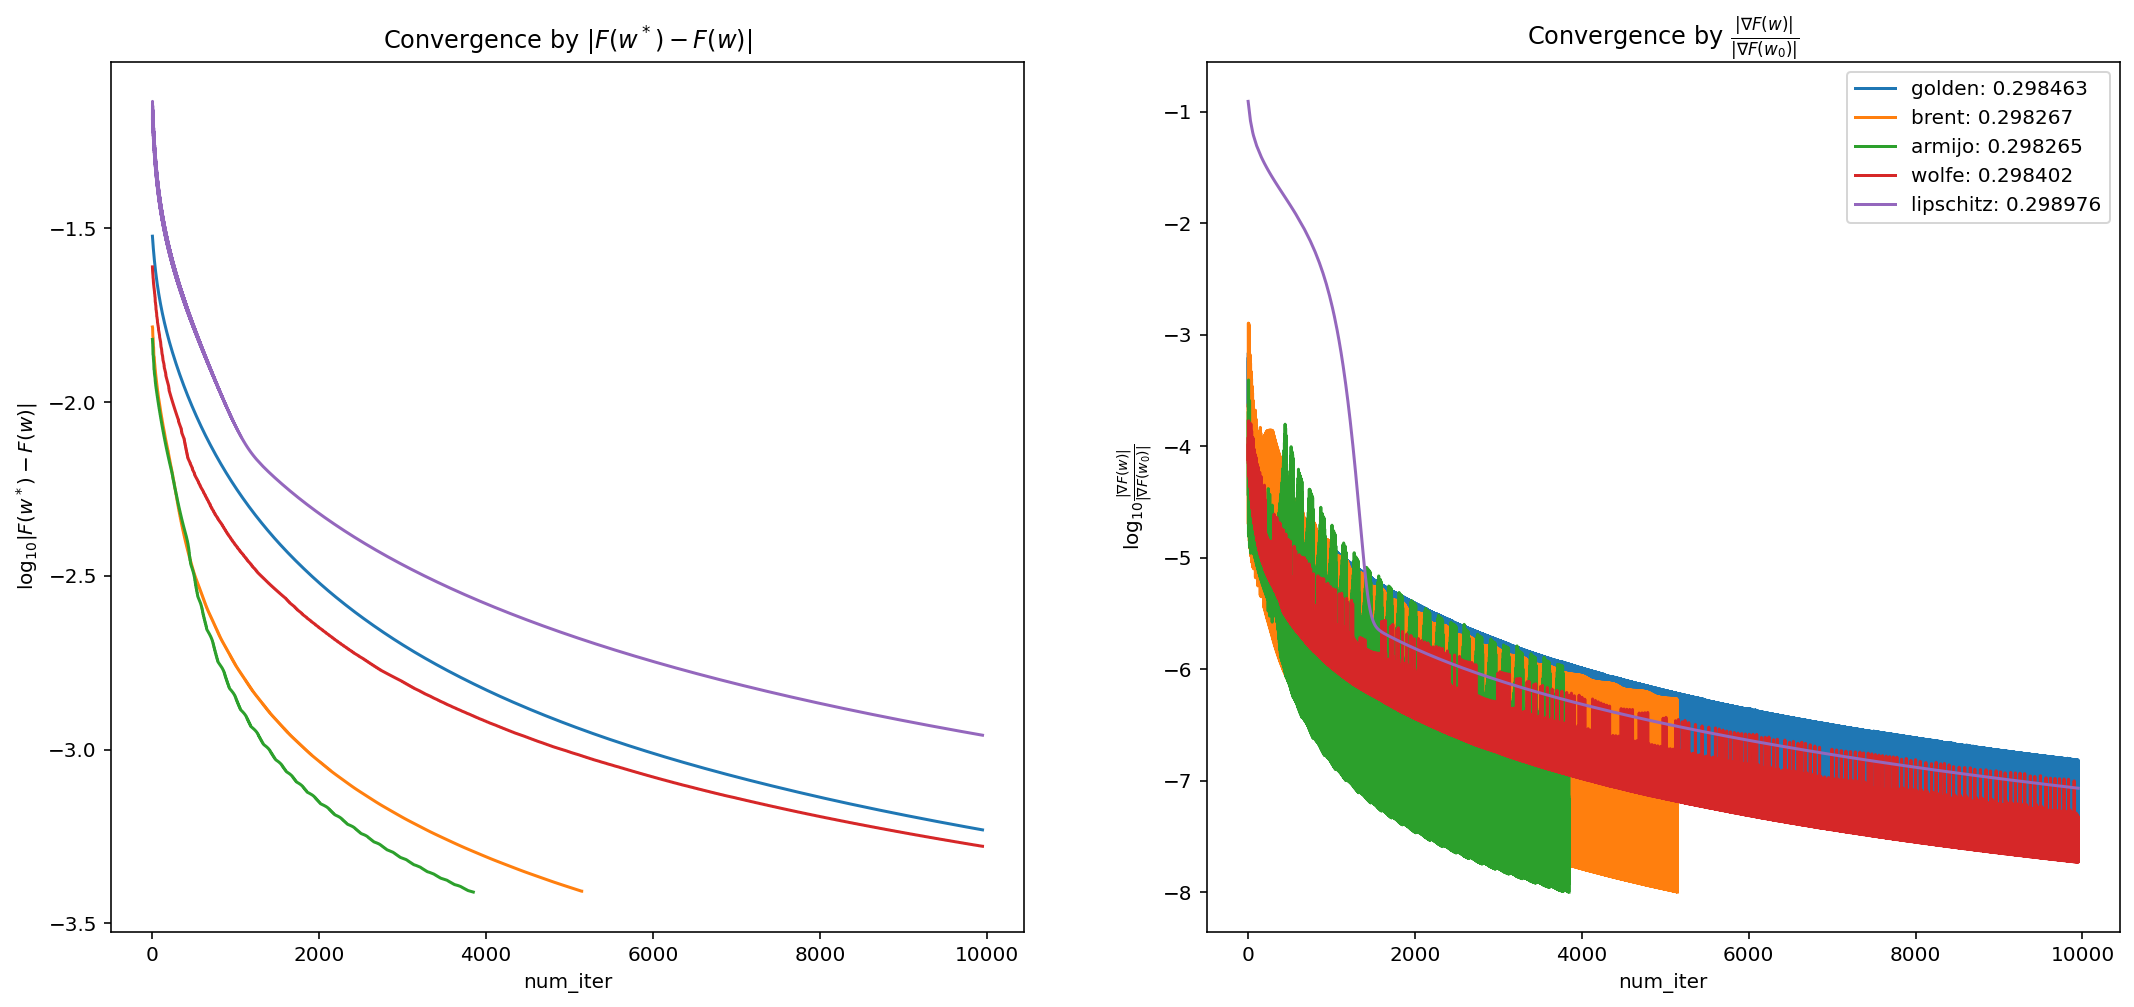

In [117]:
plot_metric(log["a1a"], "gradient descent", "num_iter", offset=50)

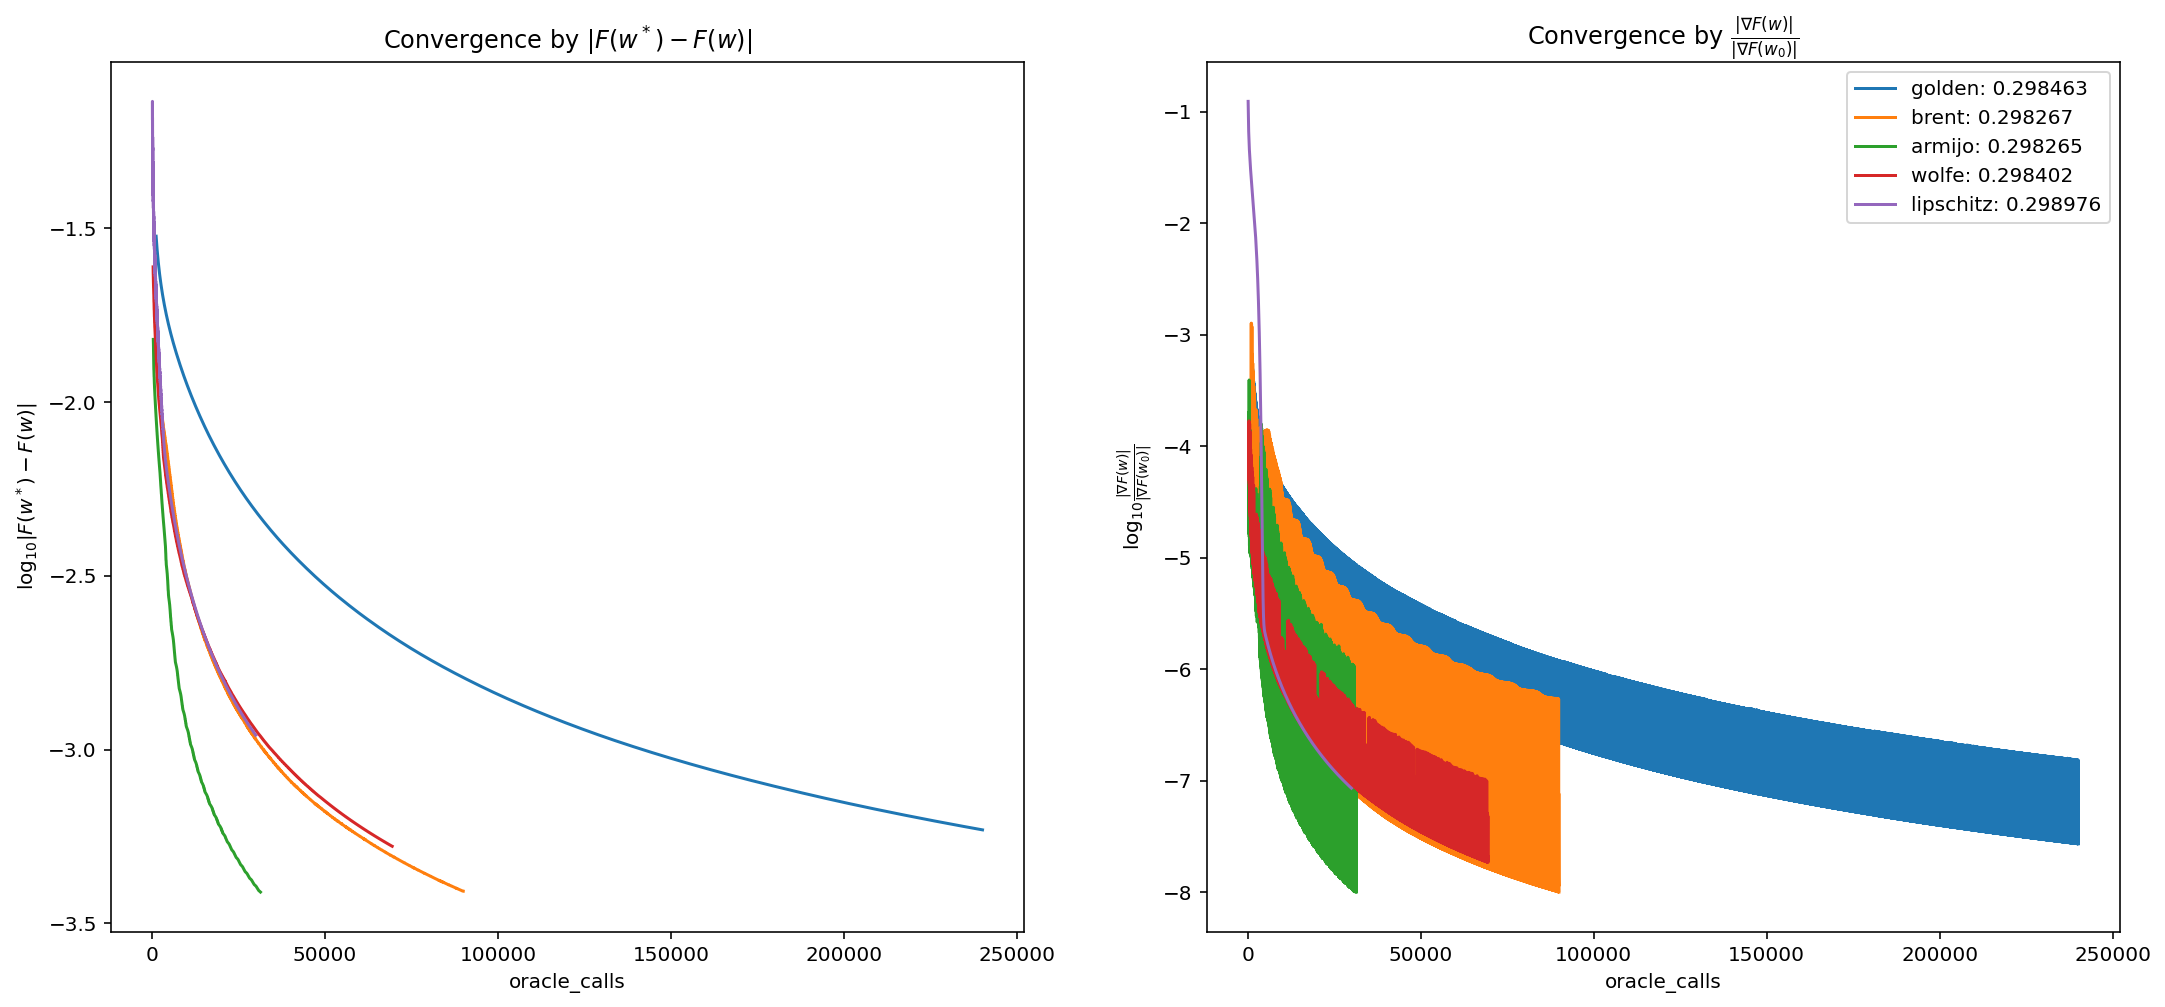

In [43]:
plot_metric(log["a1a"], "gradient descent", "oracle_calls", offset=50)

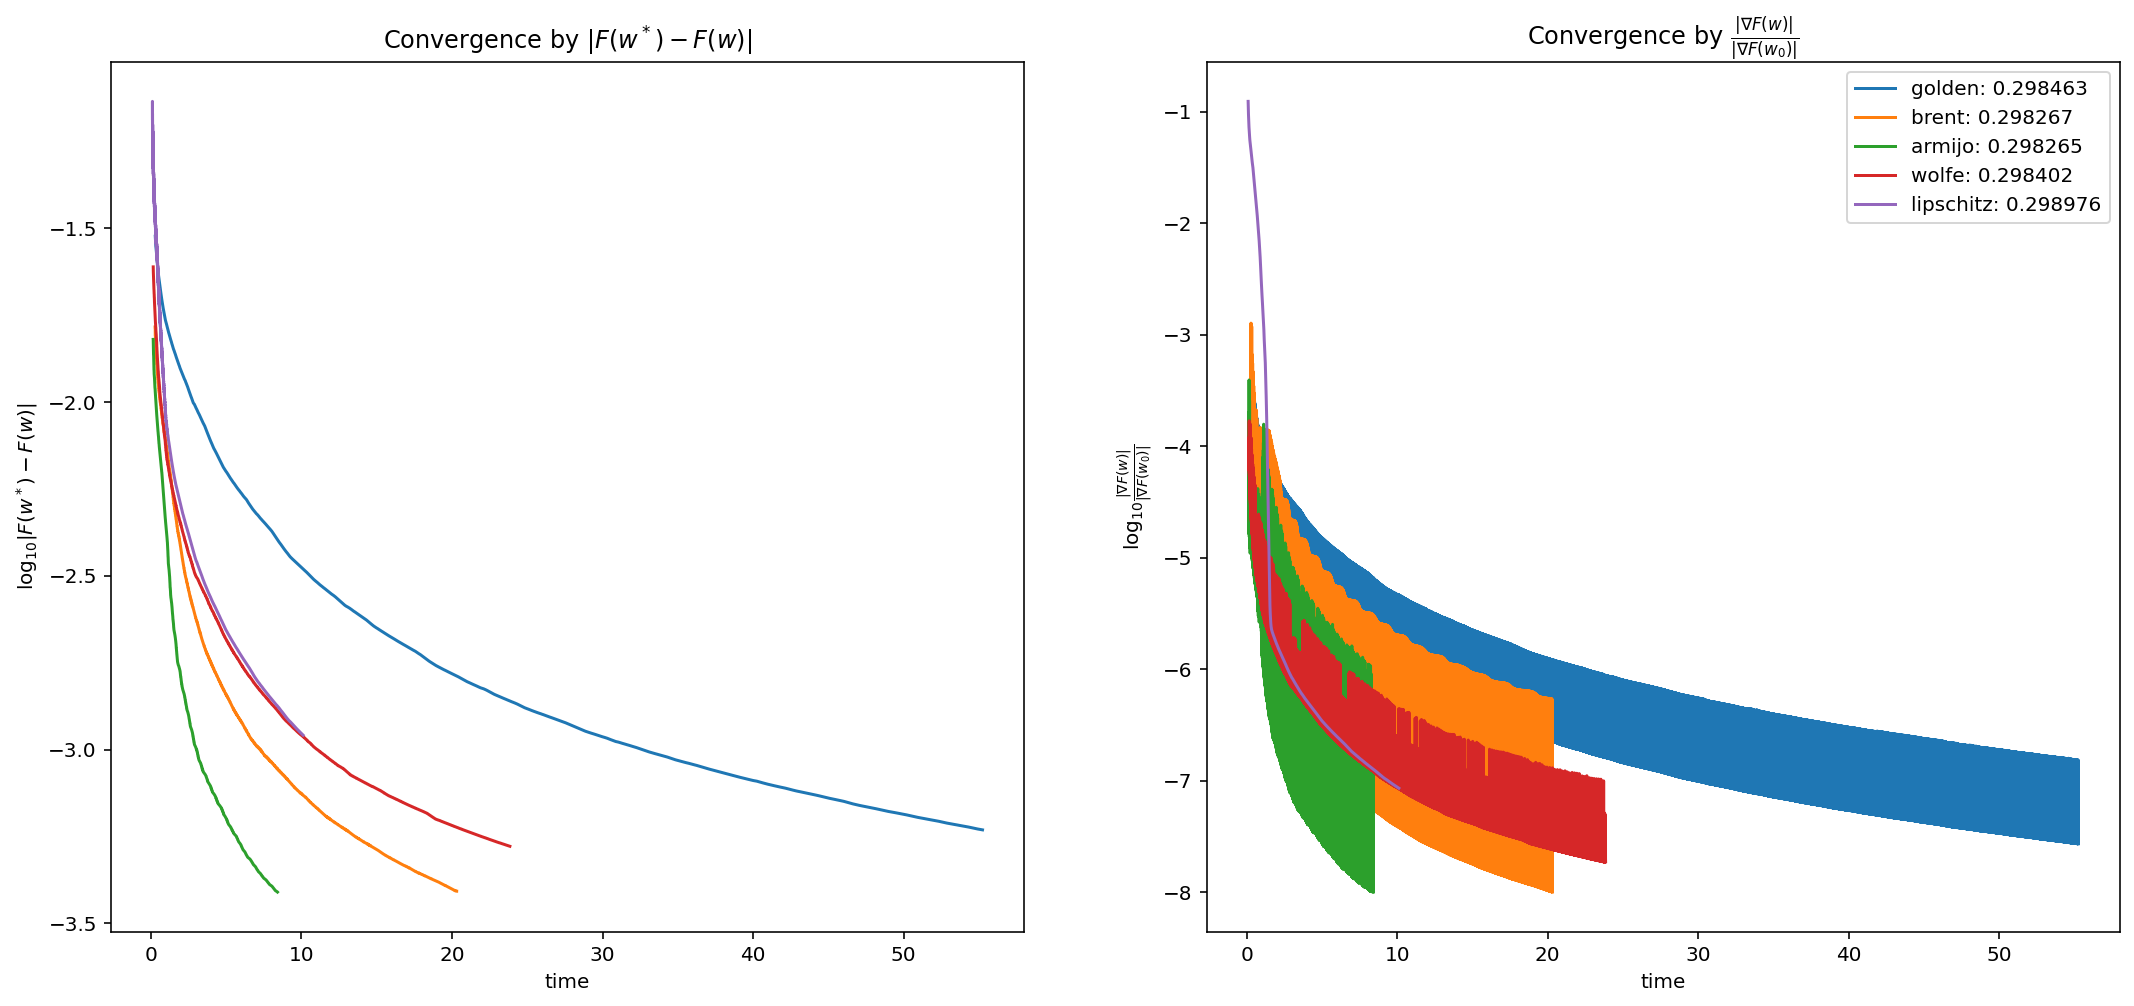

In [44]:
plot_metric(log["a1a"], "gradient descent", "time", offset=50)

## Newton

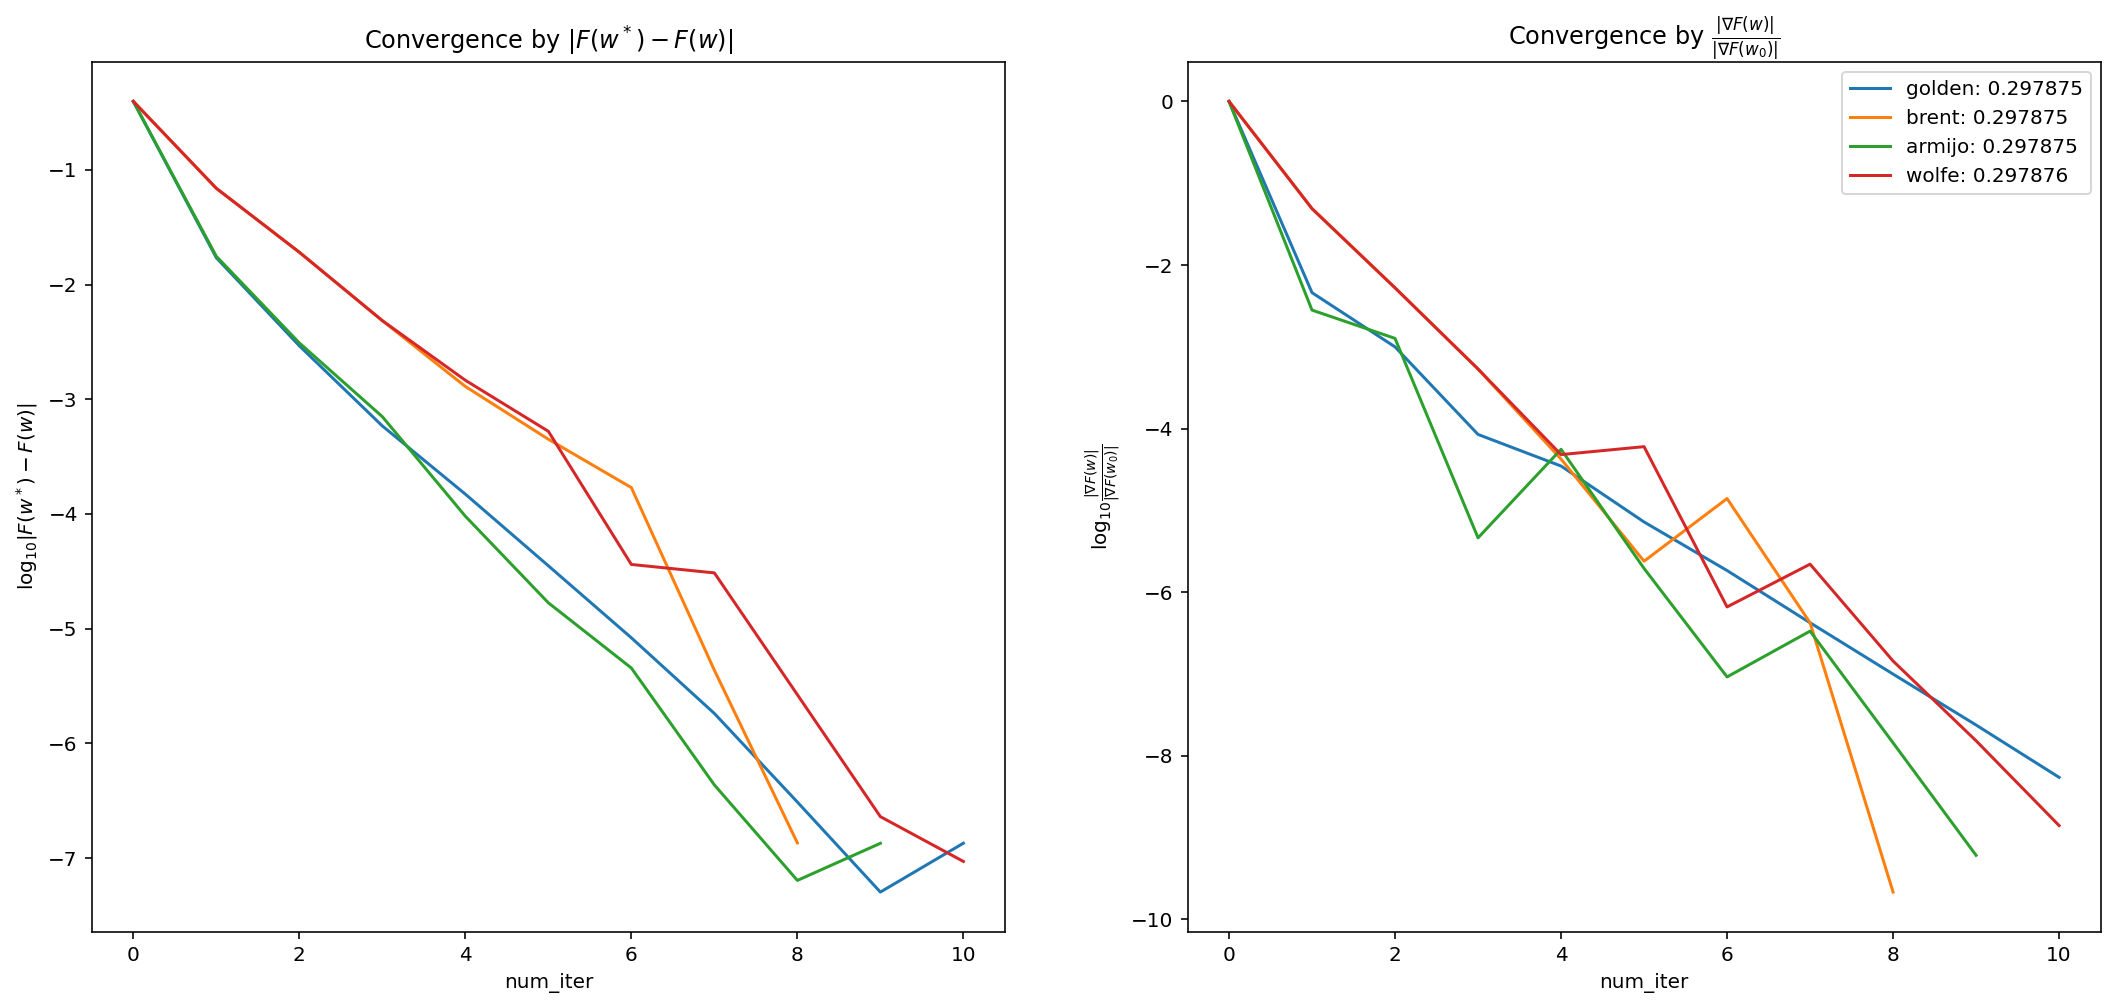

In [45]:
plot_metric(log["a1a"], "newton", "num_iter")

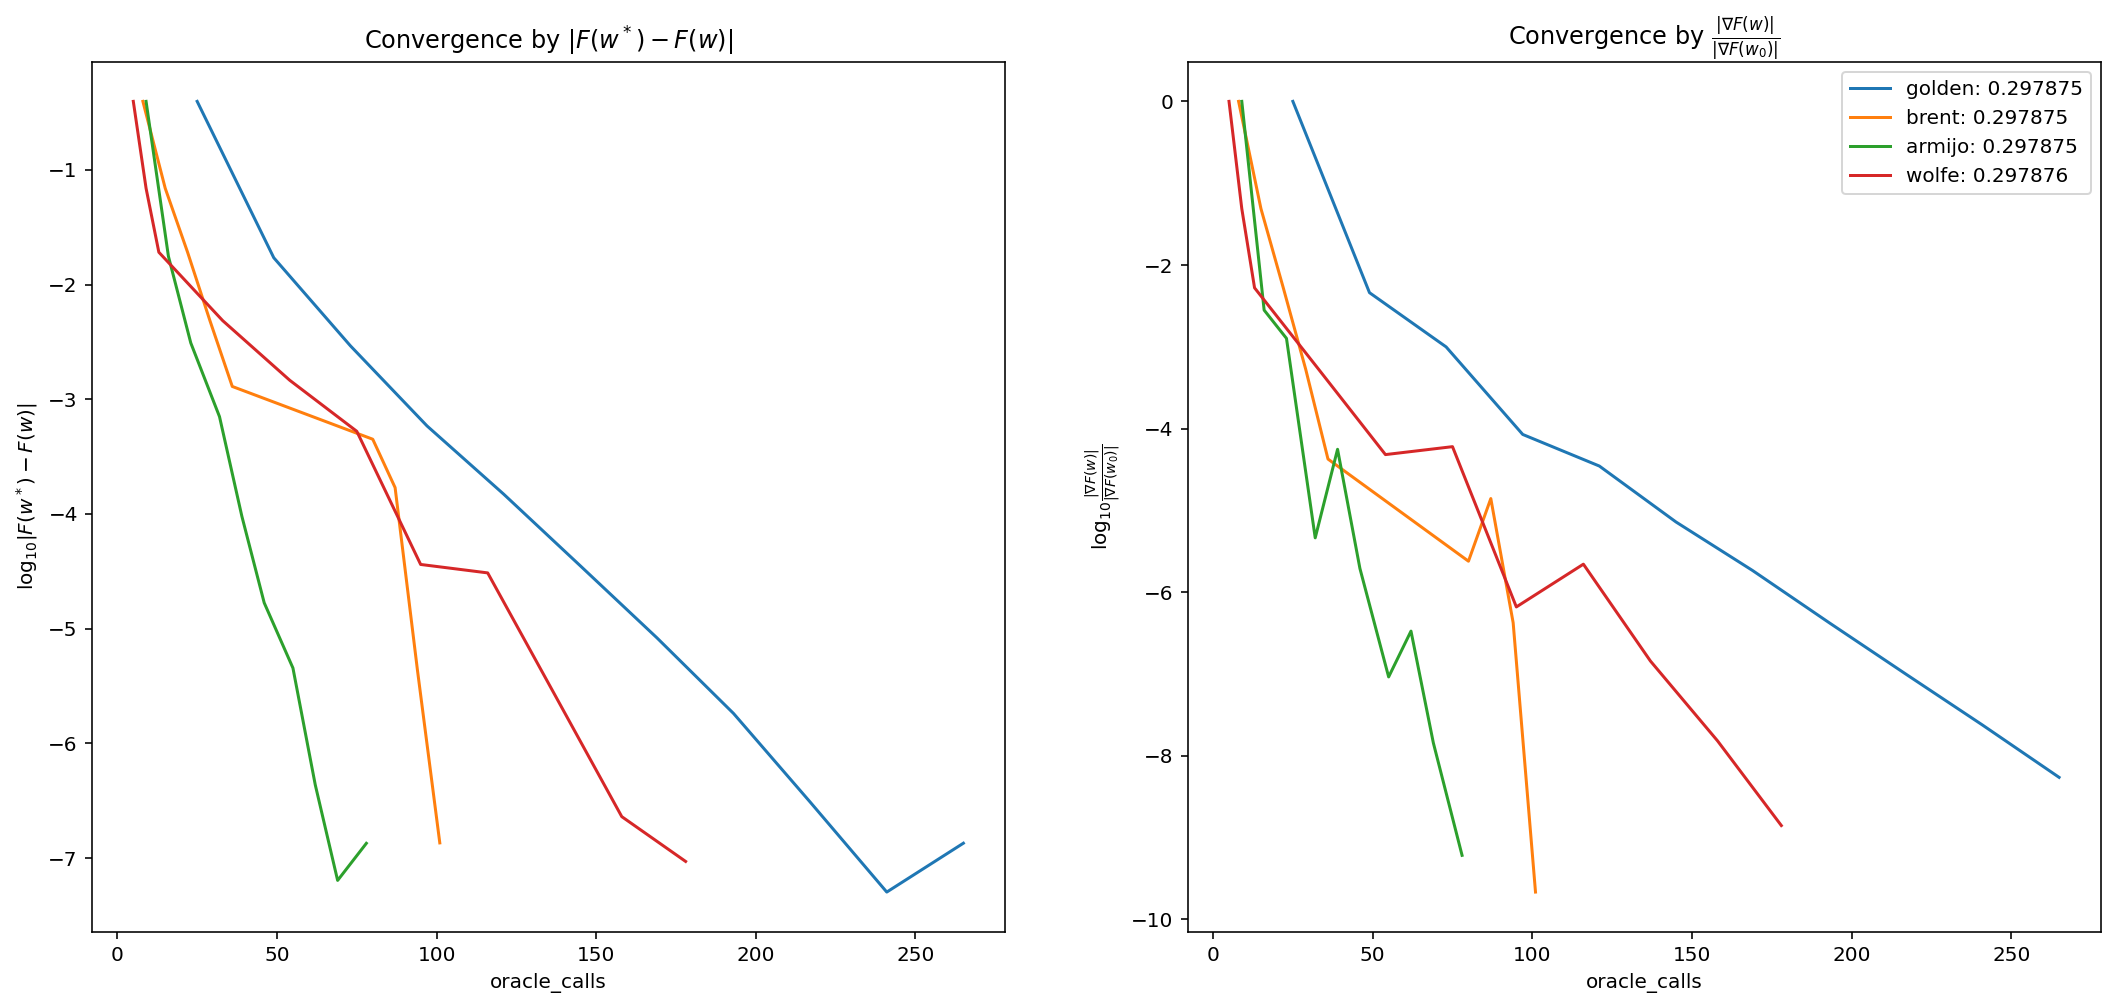

In [46]:
plot_metric(log["a1a"], "newton", "oracle_calls")

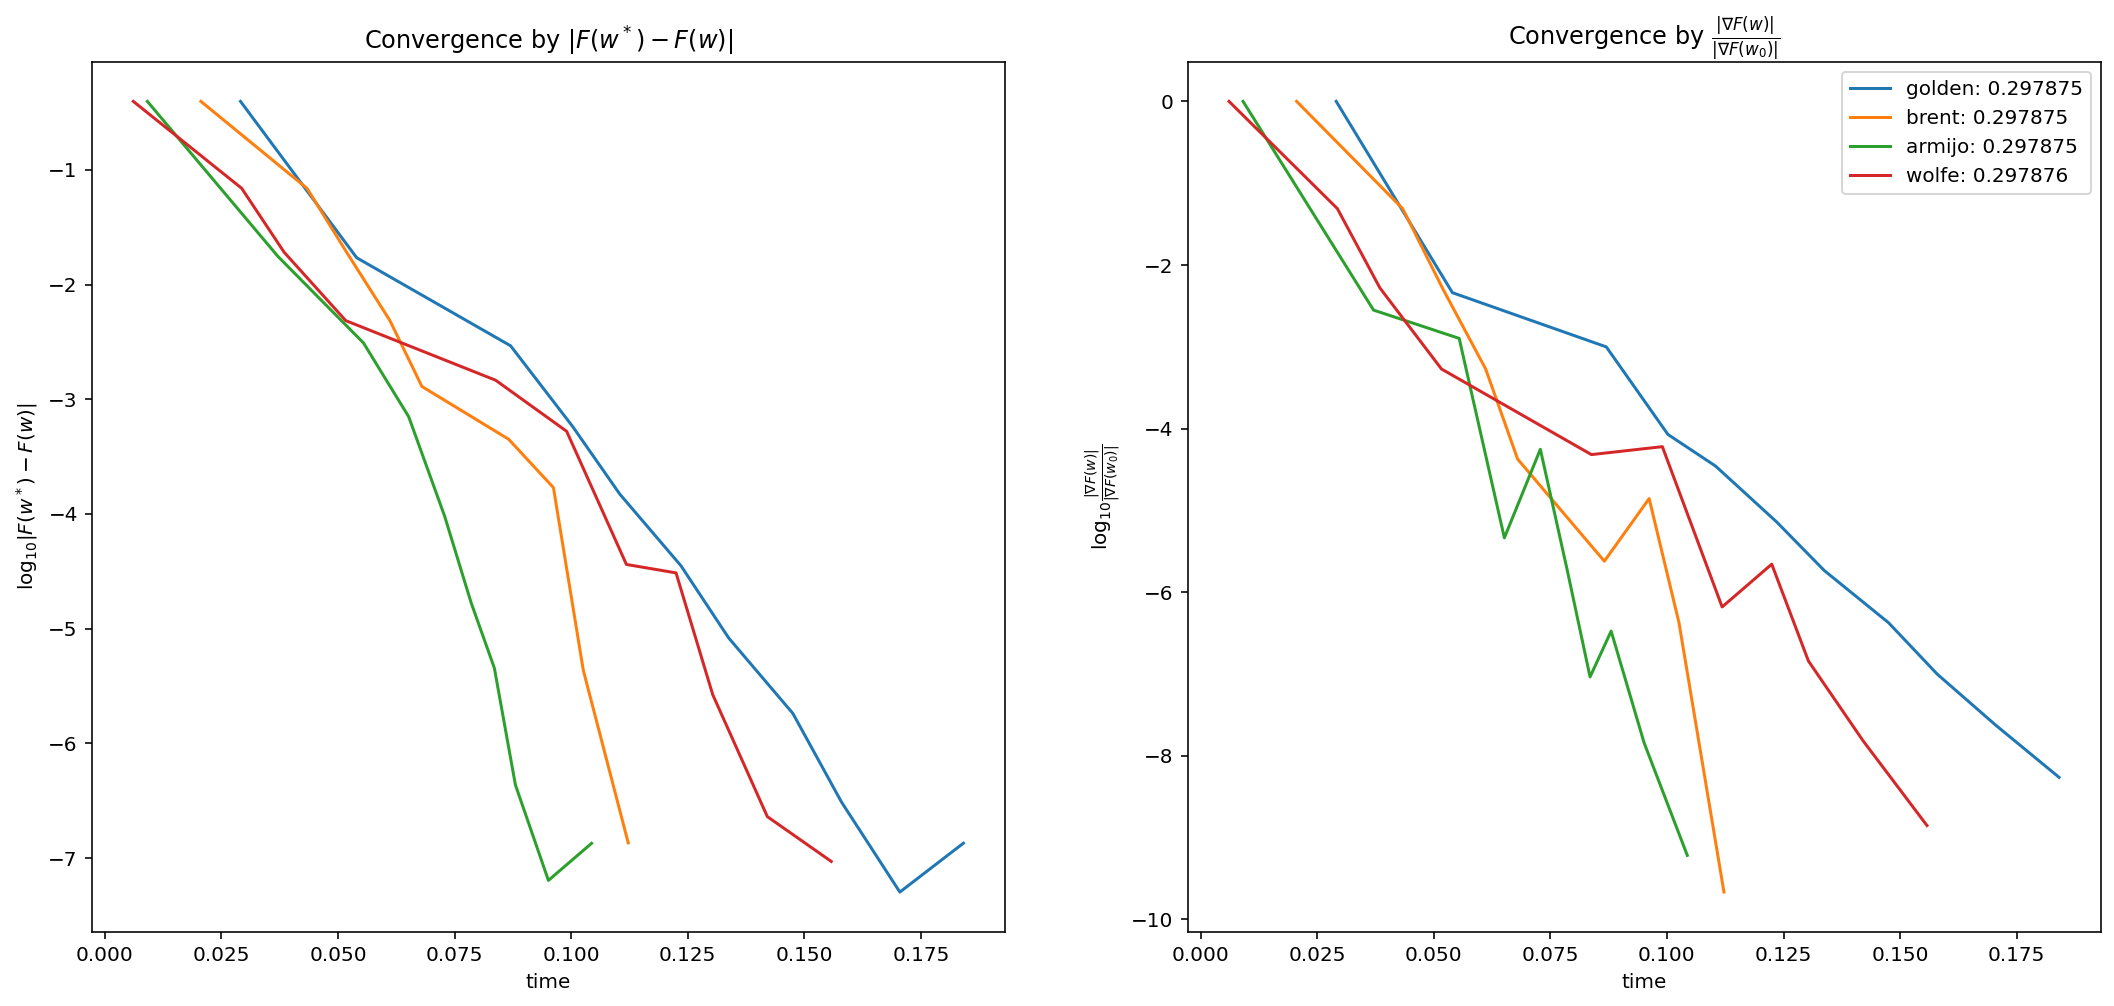

In [47]:
plot_metric(log["a1a"], "newton", "time")

## Hessian-Free Newton

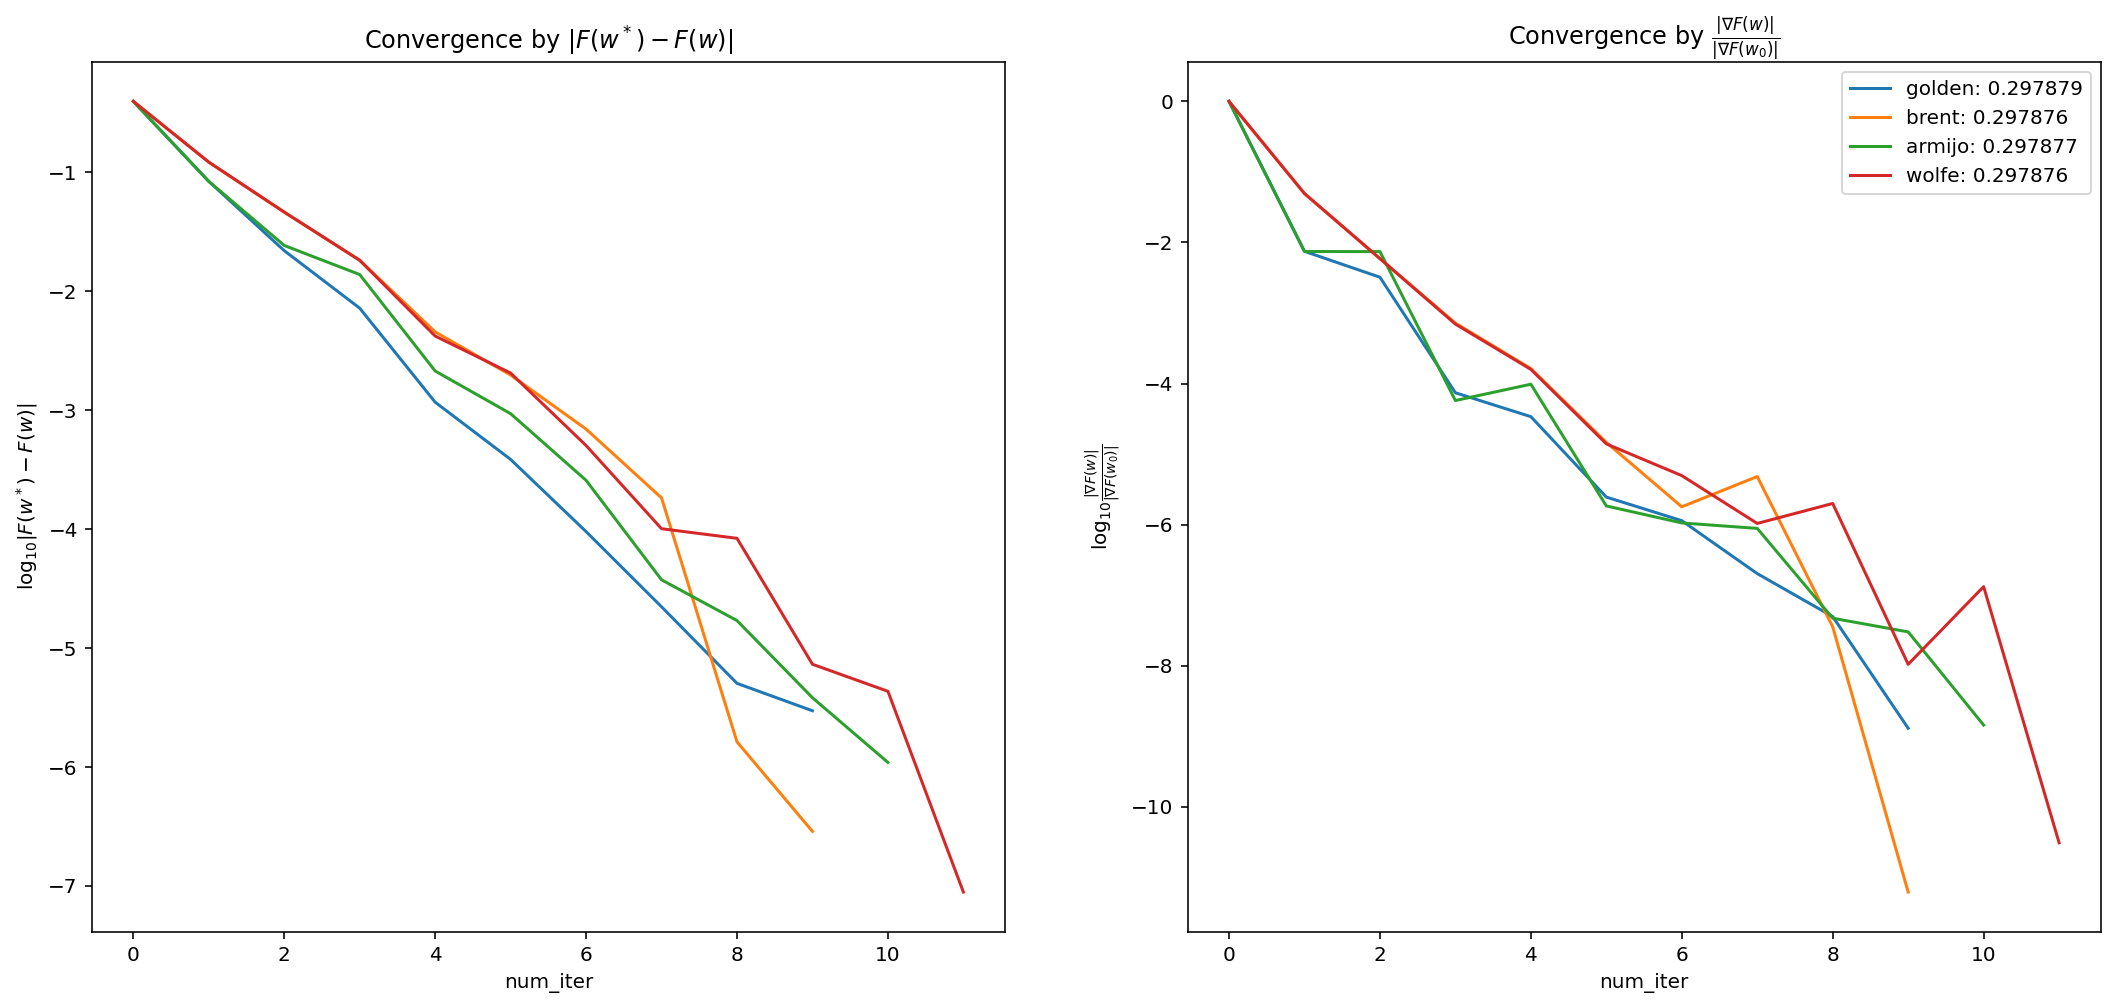

In [48]:
plot_metric(log["a1a"], "hf_newton", "num_iter")

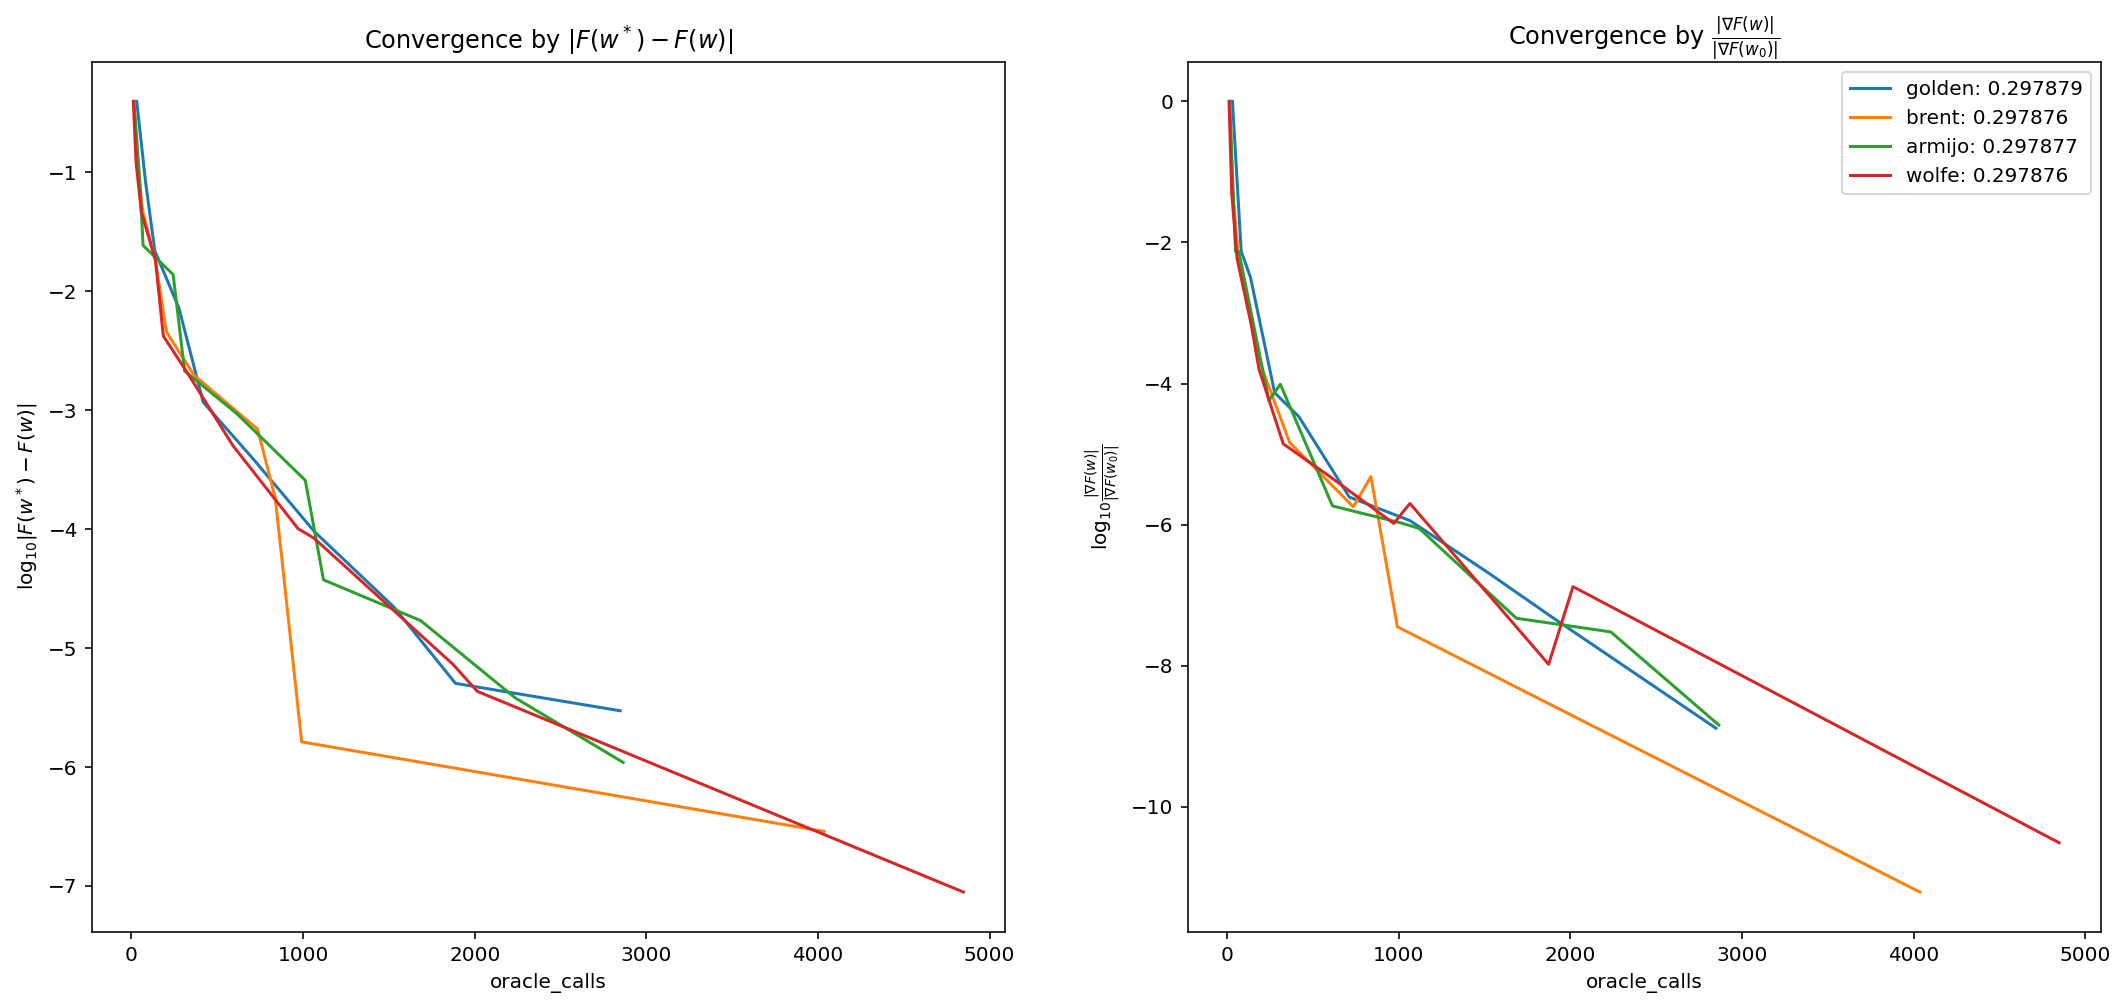

In [49]:
plot_metric(log["a1a"], "hf_newton", "oracle_calls")

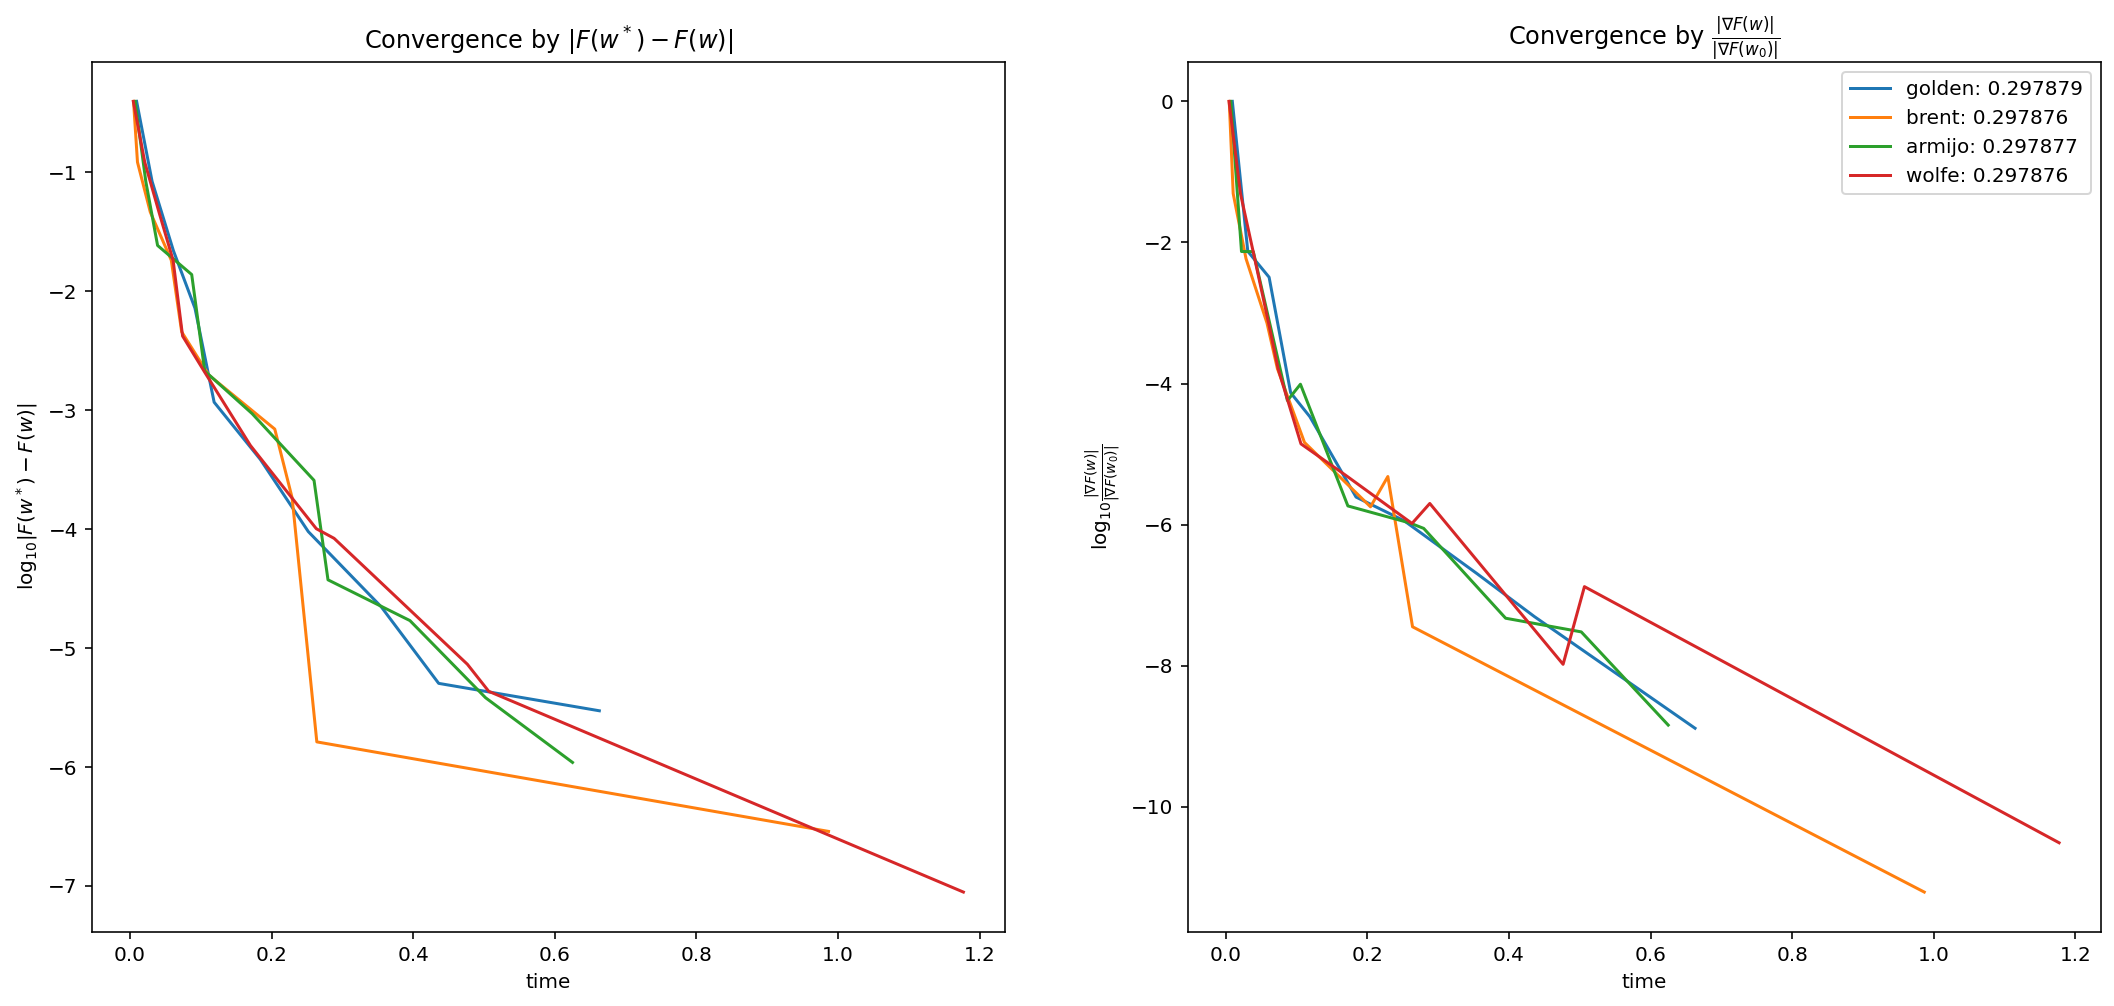

In [50]:
plot_metric(log["a1a"], "hf_newton", "time")

# Breast-cancer dataset

<table>
    <tr>
    <th style="text-align:center"> Gradient Descent </th>
    <th style="text-align:center"> Newton </th>
    <th style="text-align:center"> Hessian-Free Newton </th>
    </tr>
<tr><td>

| line search   |   entropy |   num iter |   oracle calls |   time, s |
|---------------|-----------|------------|----------------|-----------|
| golden        | 0.0754572 |        324 |           8091 |      2.05 |
| brent         | 0.0754646 |        149 |           6835 |      1.01 |
| armijo        | 0.0754031 |        904 |           8136 |      1.74 |
| wolfe         | 0.075468  |        273 |           3171 |      0.69 |
| lipschitz     | 0.0754685 |       2790 |           8371 |      2.59 |

</td><td>
    
| line search   |   entropy |   num iter |   oracle calls |   time, s |
|---------------|-----------|------------|----------------|-----------|
| golden        | 0.0753191 |          5 |            121 |      0.05 |
| brent         | 0.0753187 |          8 |             57 |      0.03 |
| armijo        | 0.0753243 |          5 |             38 |      0.02 |
| wolfe         | 0.0753187 |          8 |             33 |      0.02 |
    
</td><td>
    
| line search   |   entropy |   num iter |   oracle calls |   time, s |
|---------------|-----------|------------|----------------|-----------|
| golden        | 0.0753187 |          6 |            310 |      0.06 |
| brent         | 0.0753192 |          8 |            210 |      0.07 |
| armijo        | 0.0753188 |          7 |            238 |      0.04 |
| wolfe         | 0.0753223 |         10 |            349 |      0.06 |
    
</td></tr> 

</table>

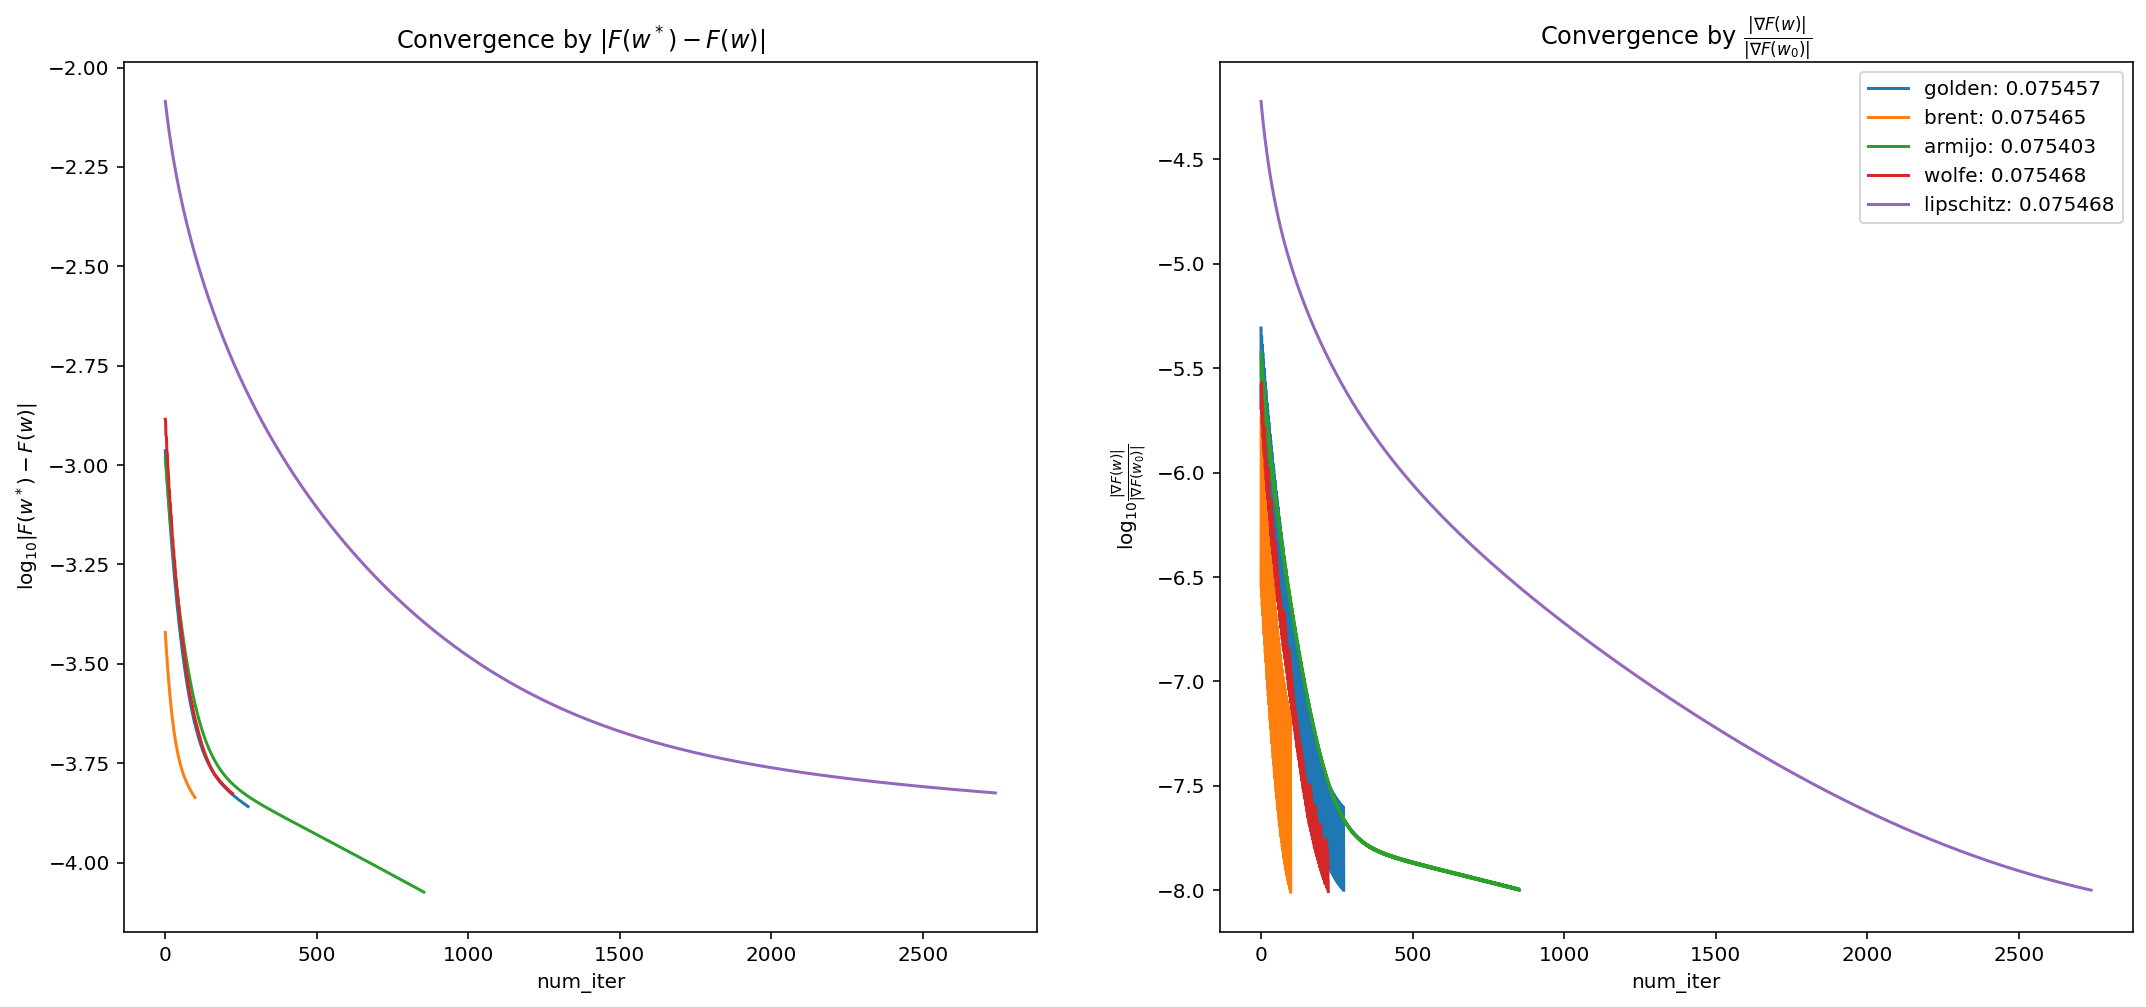

In [58]:
plot_metric(log["breast-cancer_scale"], "gradient descent", "num_iter", offset=50)

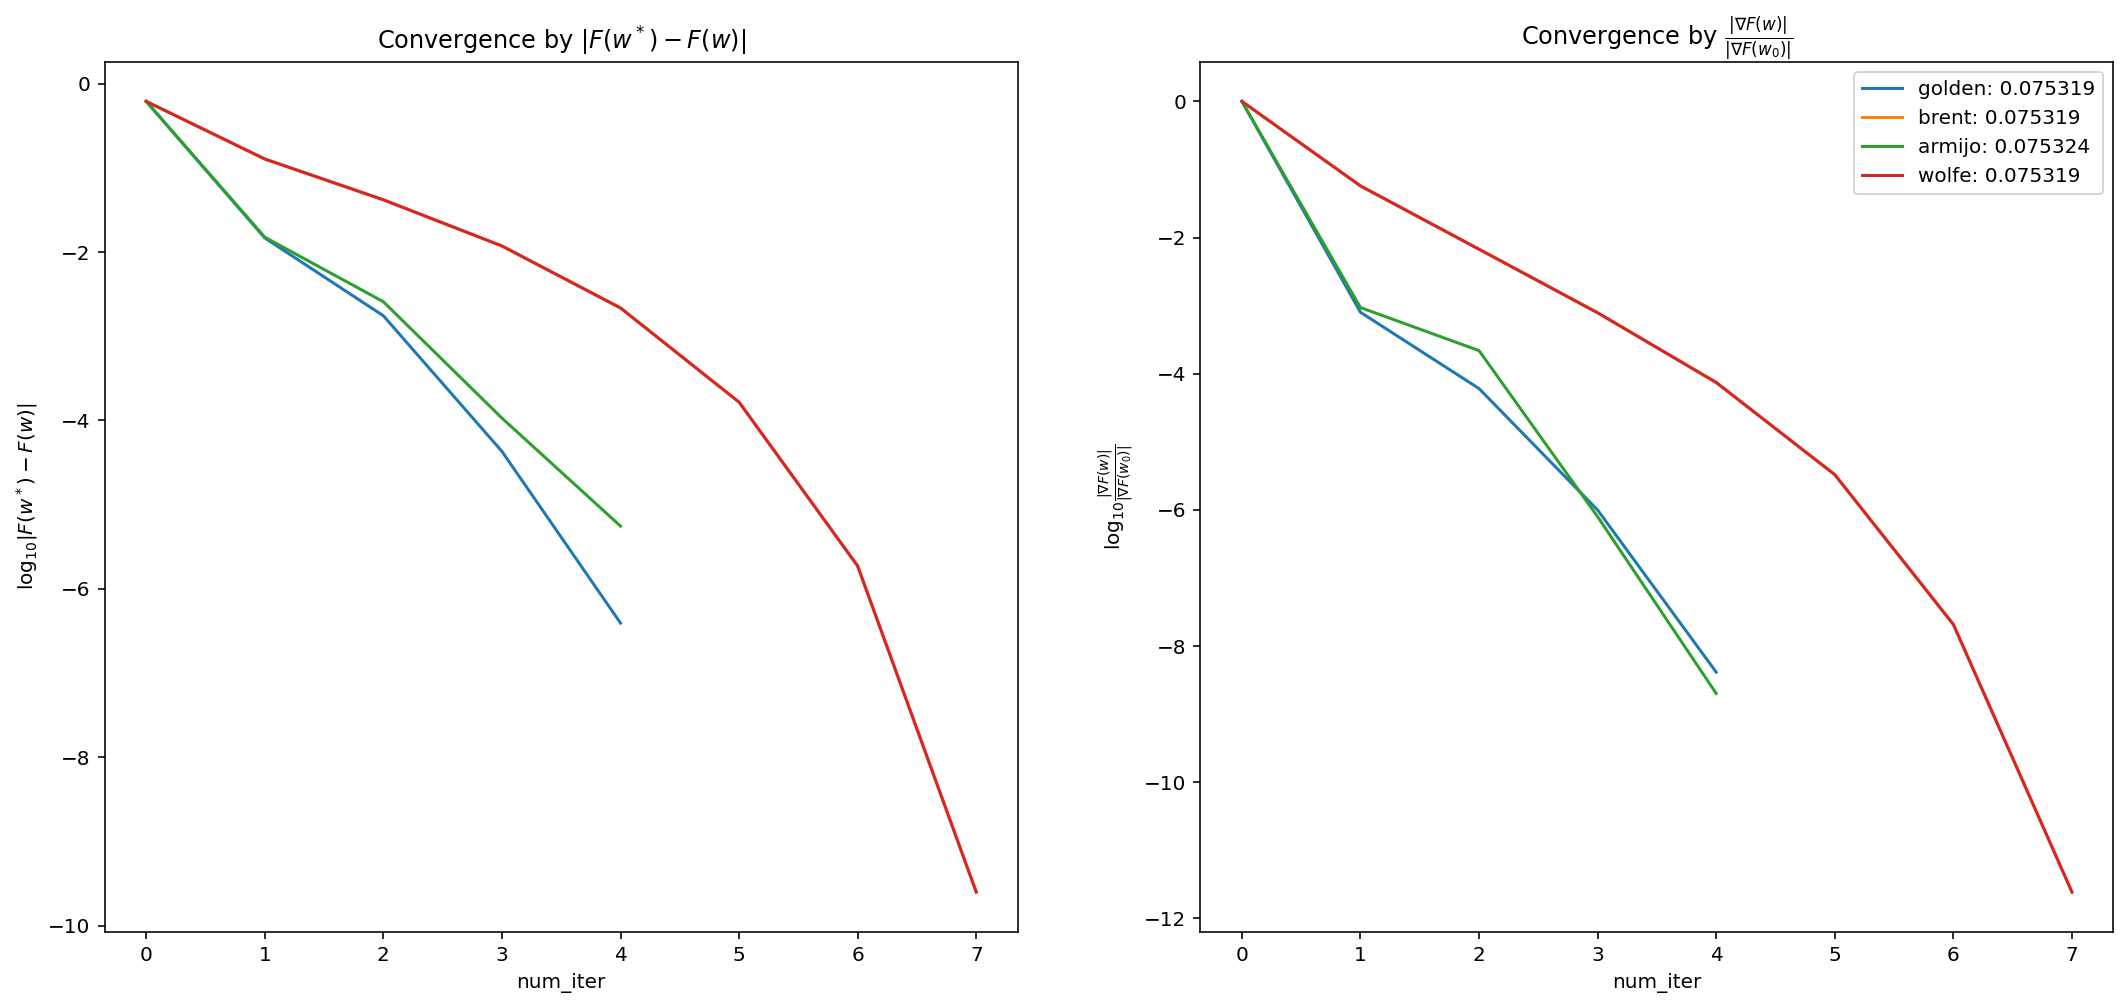

In [60]:
plot_metric(log["breast-cancer_scale"], "newton", "num_iter")

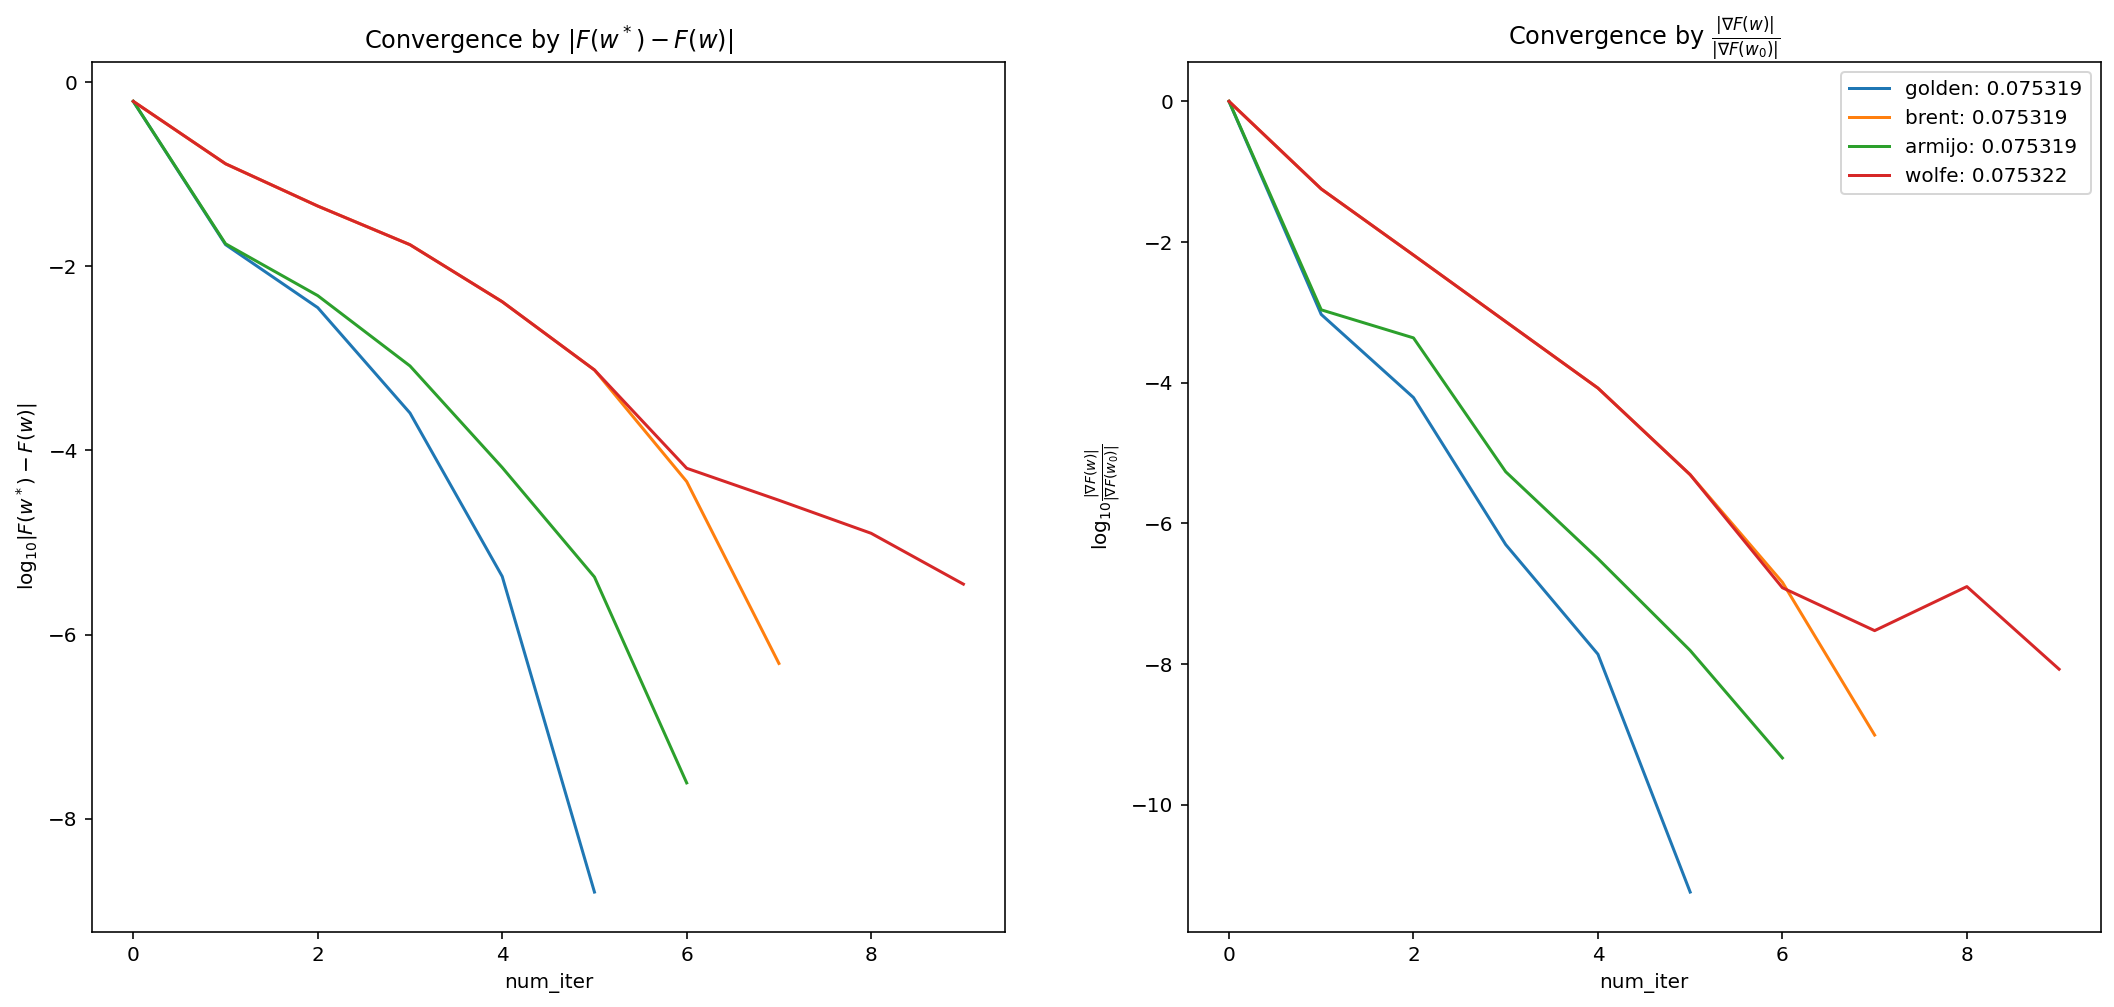

In [64]:
plot_metric(log["breast-cancer_scale"], "hf_newton", "num_iter")

# Synthetic dataset

<table>
    <tr>
    <th style="text-align:center"> Gradient Descent </th>
    <th style="text-align:center"> Newton </th>
    <th style="text-align:center"> Hessian-Free Newton </th>
    </tr>
<tr><td>

| line search   |    entropy |   num iter |   oracle calls |   time, s |
|---------------|------------|------------|----------------|-----------|
| golden        | 0.00211794 |       2585 |          67208 |      5.98 |
| brent         | 0.00239324 |       1473 |          62375 |      6.34 |
| armijo        | 0.00182728 |       2978 |          29230 |      4.01 |
| wolfe         | 0.00251053 |       1704 |          33891 |      3.54 |
| lipschitz     | 0.0123446  |      10000 |          30001 |      4.81 |

</td><td>
    
| line search   |      entropy |   num iter |   oracle calls |   time, s |
|---------------|--------------|------------|----------------|-----------|
| golden        | -1.00009e-12 |          6 |            158 |      0.09 |
| brent         | -1.00009e-12 |          7 |            194 |      0.03 |
| armijo        | -1.00009e-12 |          6 |             77 |      0.01 |
| wolfe         | -1.00009e-12 |          9 |             85 |      0.02 |
    
</td><td>
    
| line search   |      entropy |   num iter |   oracle calls |   time, s |
|---------------|--------------|------------|----------------|-----------|
| golden        |  6.43325e-05 |          6 |            214 |      0.04 |
| brent         | -1.00009e-12 |          6 |            237 |      0.04 |
| armijo        | -1.00009e-12 |          6 |            116 |      0.02 |
| wolfe         | -1.00009e-12 |          9 |            174 |      0.02 |
    
</td></tr> 

</table>

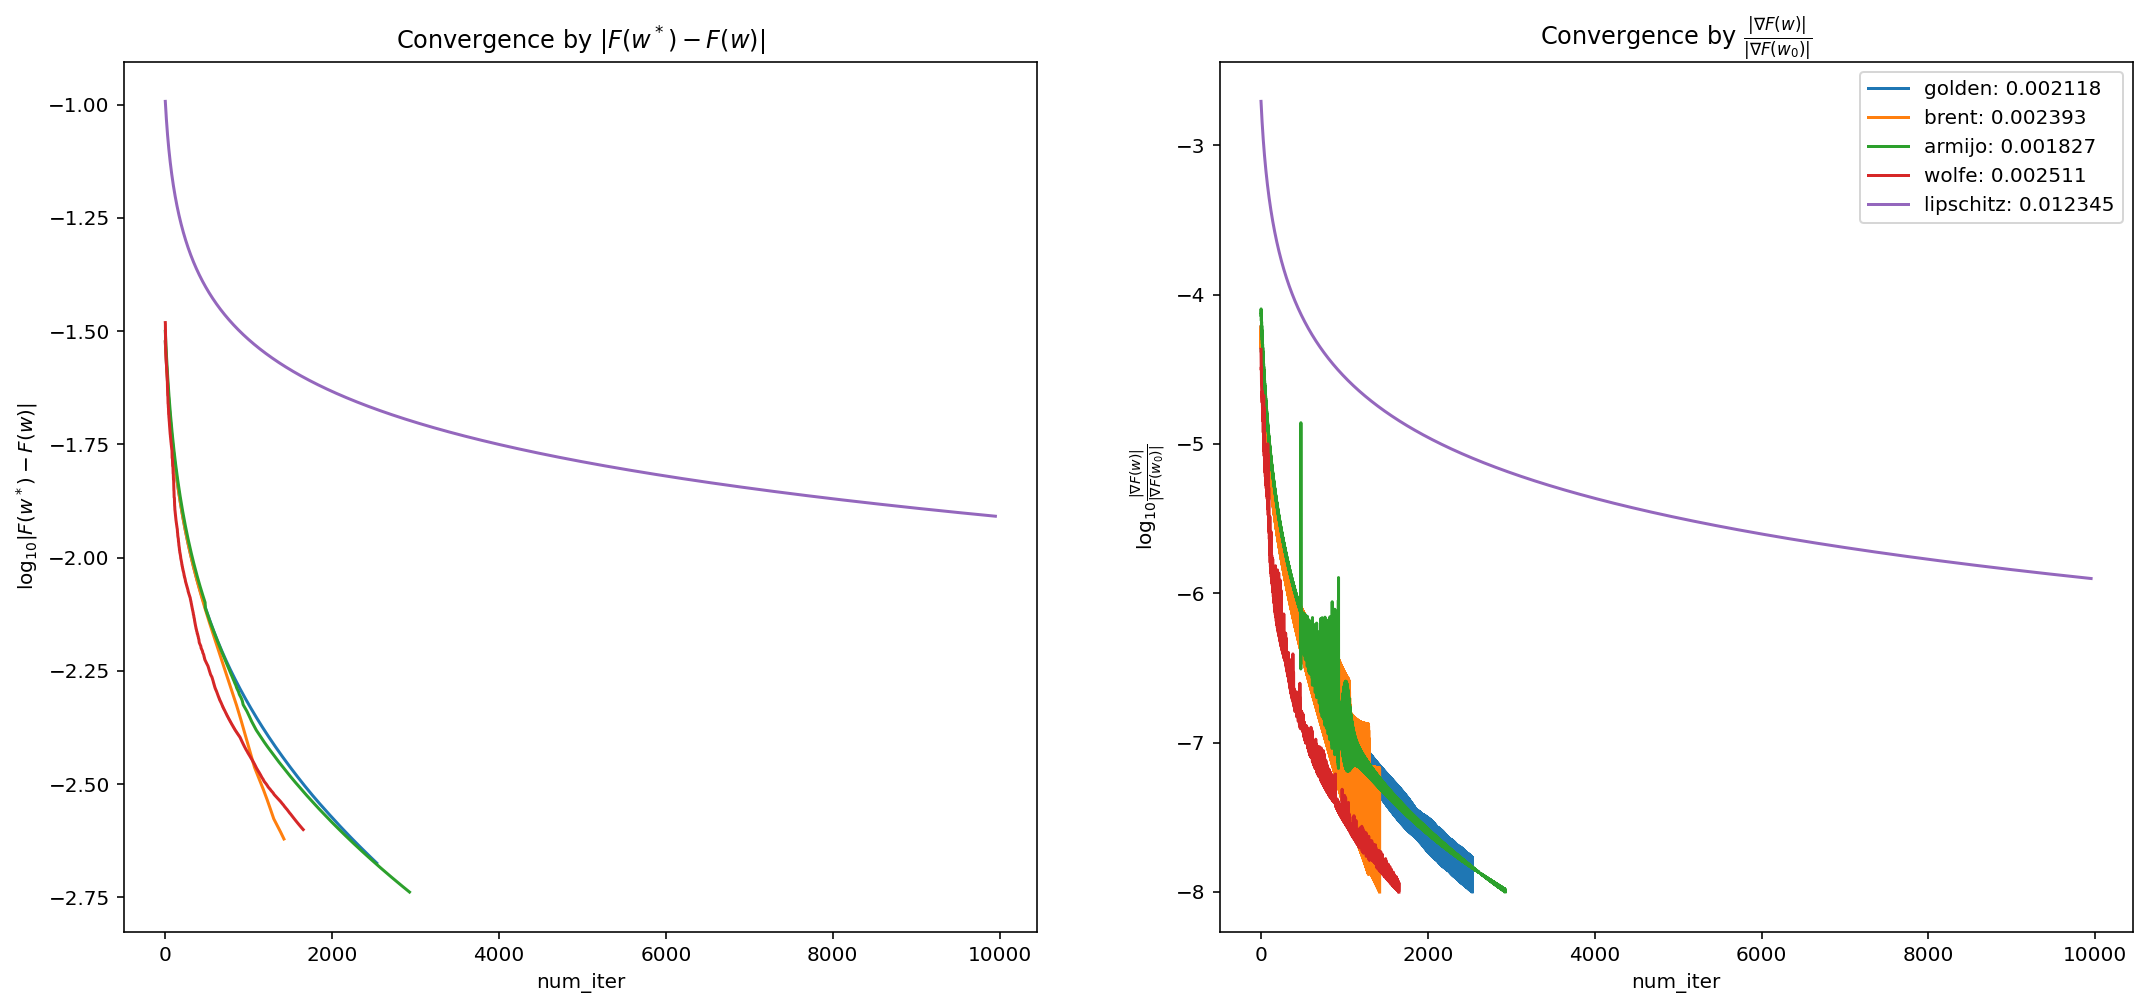

In [66]:
plot_metric(log["generated"], "gradient descent", "num_iter", offset=50)

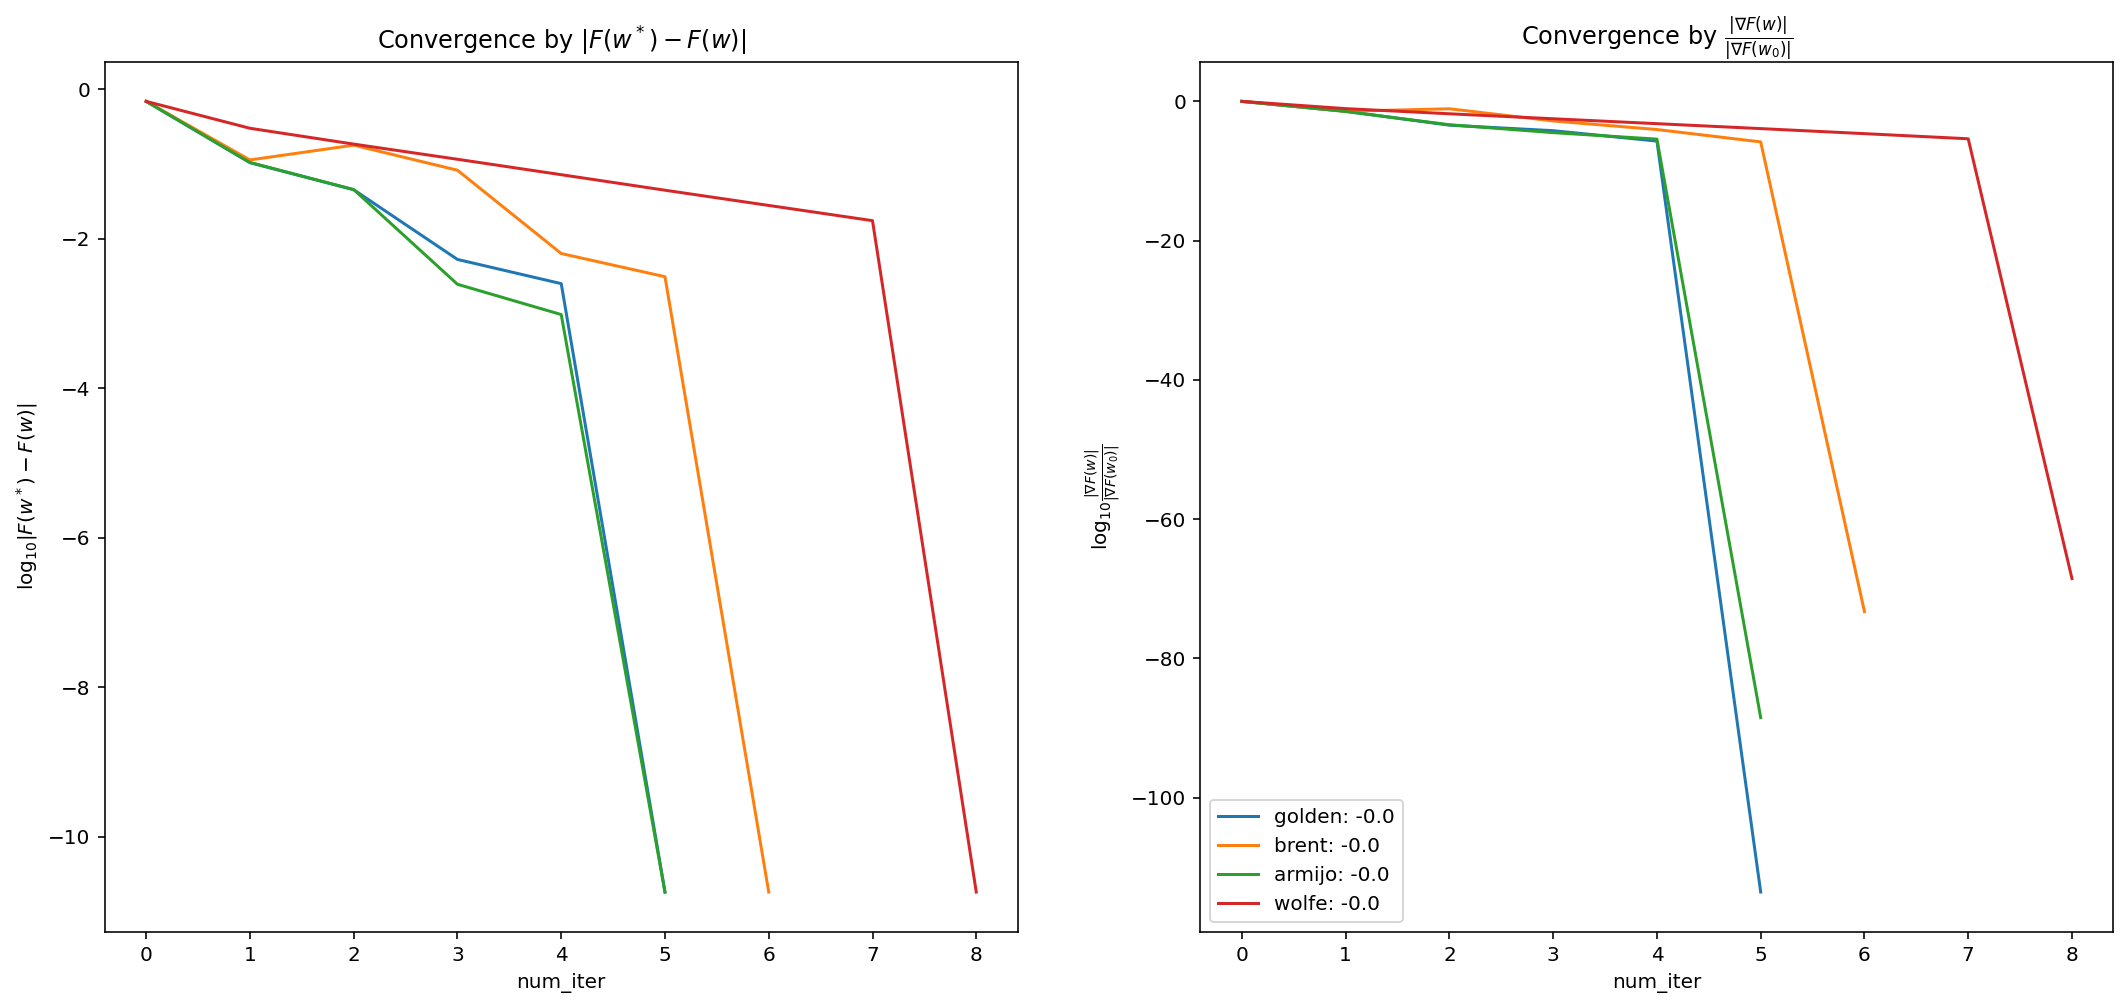

In [67]:
plot_metric(log["generated"], "newton", "num_iter")

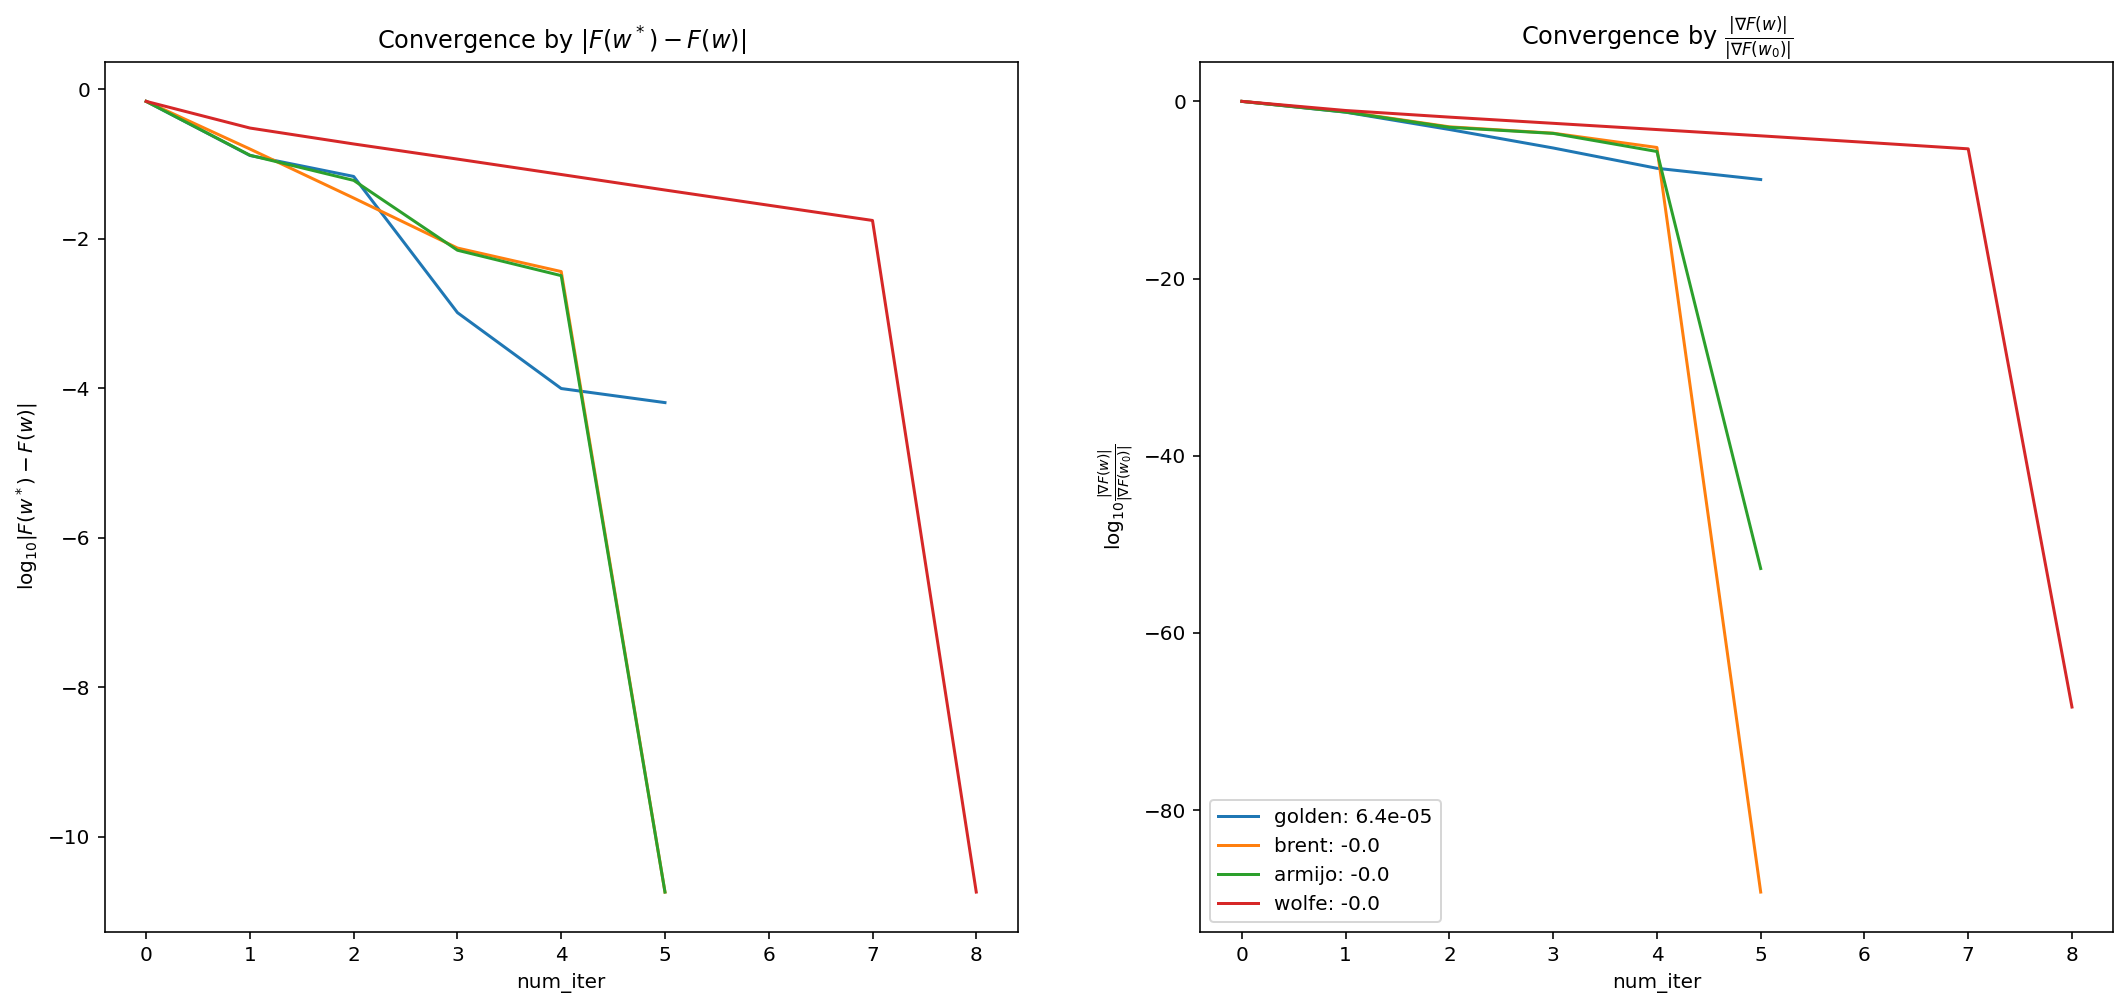

In [68]:
plot_metric(log["generated"], "hf_newton", "num_iter")

# Armijo parameters

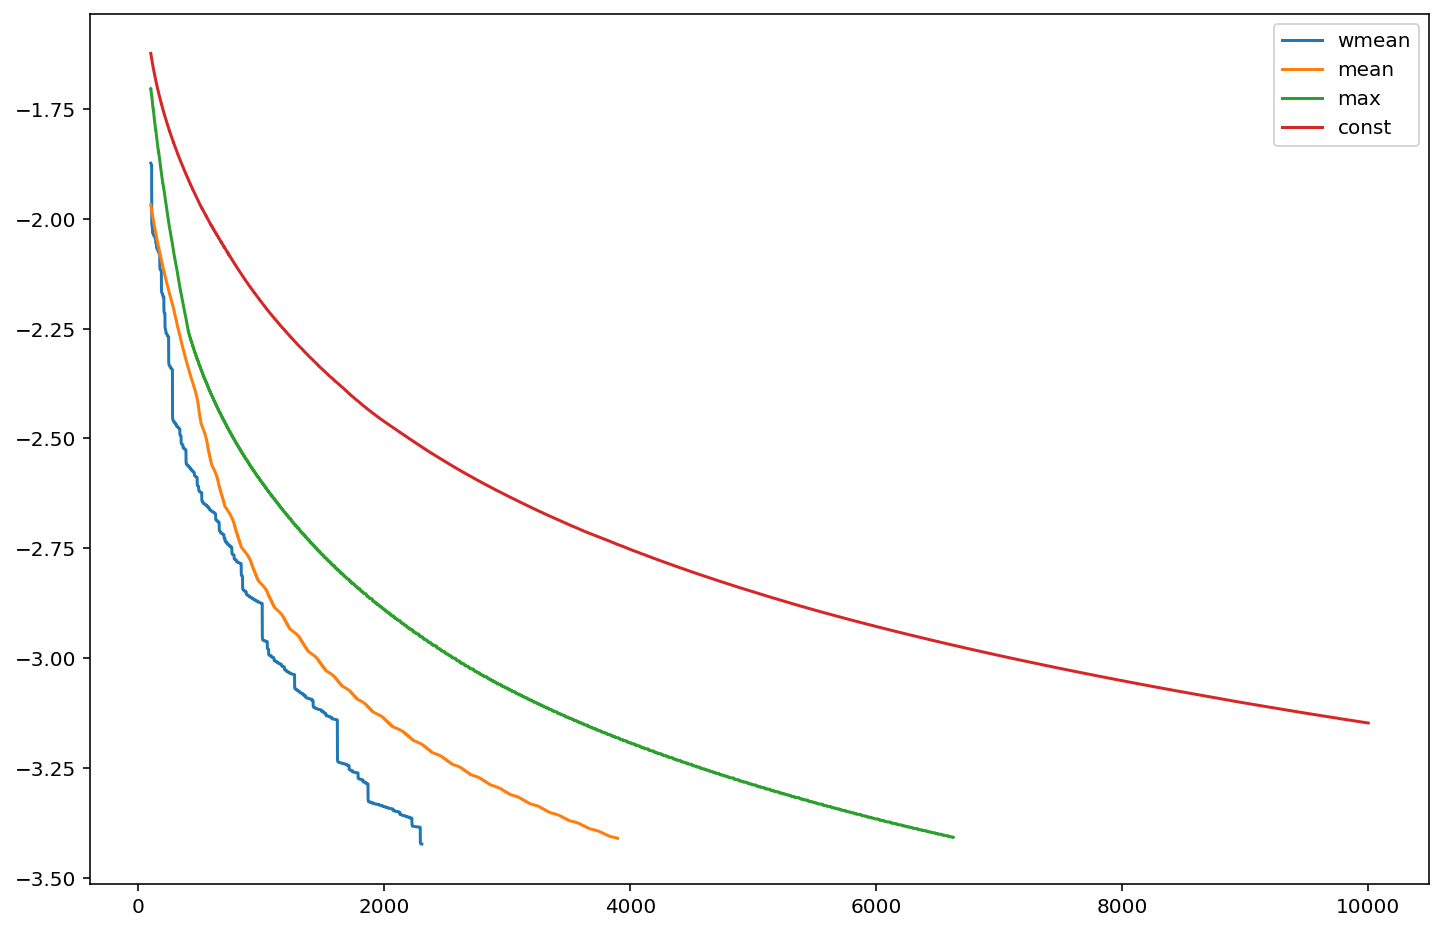

In [95]:
plt.figure(figsize=(12, 8))
for init in ["wmean", "mean", "max", "const"]:
    armijo_log = run_optimizer("data/a1a.txt", optimize_gd, line_search_method="armijo", armijo_init=init)
    info = armijo_log.get_log()
    
    plt.plot(np.arange(info["num_iter"])[100:], 
             np.log10(np.abs(info["entropy"]) - 0.2978755986559931)[100:], label=f"{init}")
plt.legend();

# Conjugate gradient parameters

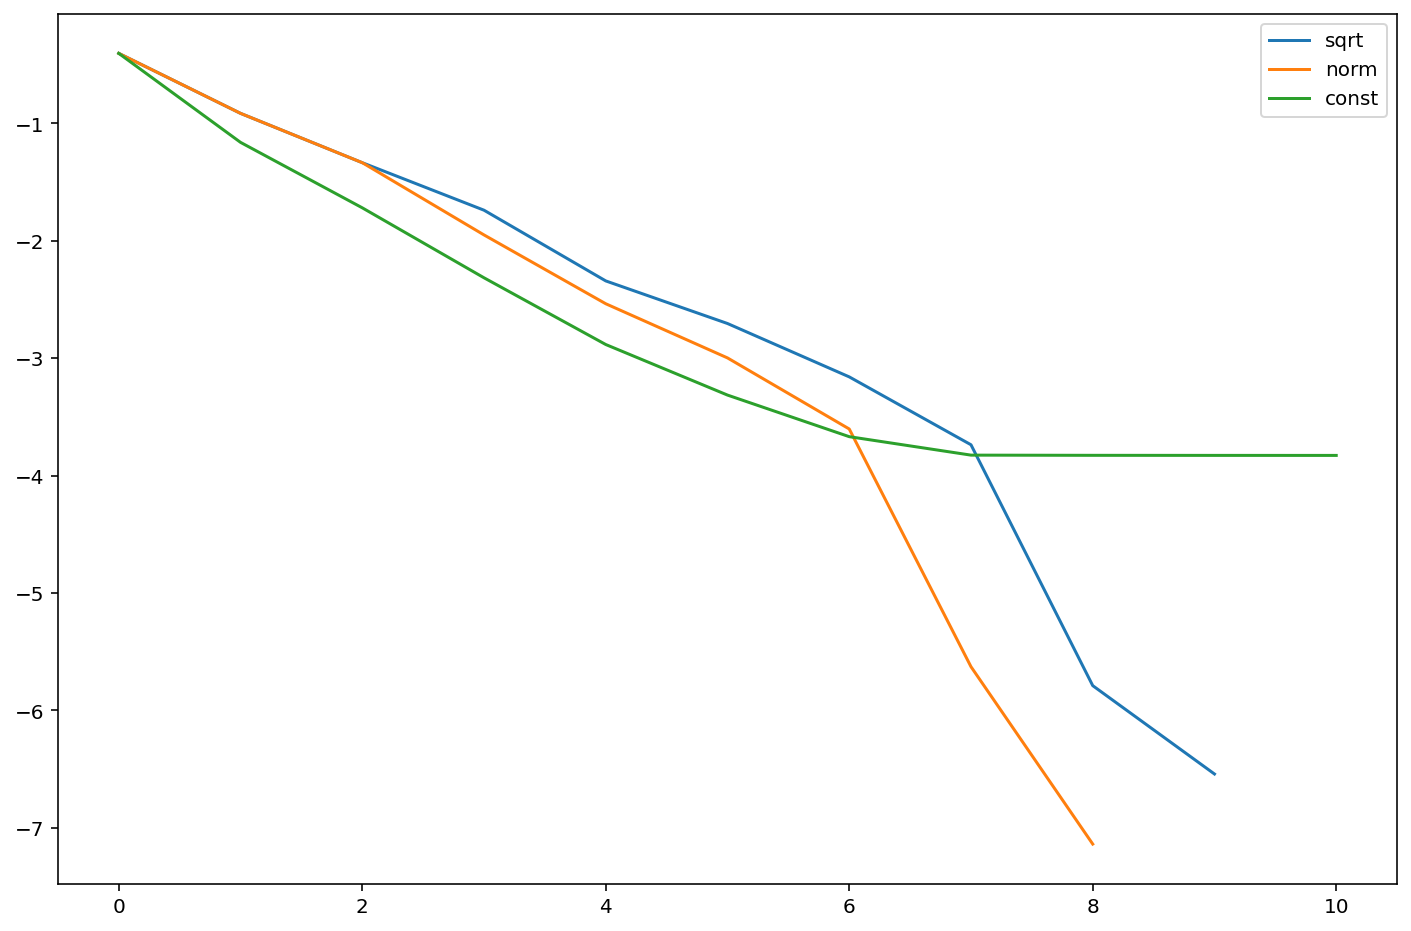

In [100]:
plt.figure(figsize=(12, 8))
for tol in ["sqrt", "norm", "const"]:
    hfn_log = run_optimizer("data/a1a.txt", optimize_hfn, line_search_method="brent", cg_tol=tol)
    info = hfn_log.get_log()
    
    plt.plot(np.arange(info["num_iter"]), 
             np.log10(np.abs(info["entropy"]) - 0.2978755986559931), label=f"{tol}")
plt.legend();